In [1]:
import os
from os import listdir
import pandas as pd
import numpy as np
import glob
import cv2
import json
from os.path import expanduser
import splitfolders
import shutil
from define_path import Def_Path

from tqdm import tqdm

import torch 
import torchvision
from torchvision import models
from torchvision.models.detection.rpn import AnchorGenerator
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torchsummary import summary

from sklearn.model_selection import train_test_split

import albumentations as A # Library for augmentations

import matplotlib.pyplot as plt 
from PIL import Image

import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate


t = torch.cuda.get_device_properties(0).total_memory
print(t)
torch.cuda.empty_cache()

r = torch.cuda.memory_reserved(0)
print(r)
a = torch.cuda.memory_allocated(0)
print(a)
# f = r-a  # free inside reserved

16908615680
0
0


In [2]:
# to generalize home directory. User can change their parent path without entering their home directory
path = Def_Path()

# parent_path =  path.home + "/Workspace/WPI/Summer2023/ws/duc_repo/src/panda_test/" + "data/kp_test_images/"
# parent_path =  path.home + "/Workspace/WPI/Summer2023/ws/duc_repo/src/panda_test/" + "data/sim_marker/"
parent_path = "/home/jc-merlab/Pictures/panda_data/panda_sim_vel/"

# root_dir = parent_path + path.year + "-" + path.month + "-" + path.day + "/"
root_dir = parent_path + "path_plan_kp_sim" + "/"

print(root_dir)

/home/jc-merlab/Pictures/panda_data/panda_sim_vel/path_plan_kp_sim/


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.cuda.set_per_process_memory_fraction(0.9, 0)
print(device)

cuda


In [4]:
# this fucntion tranforms an input image for diverseifying data for training
def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1), # Random change of brightness & contrast
        ], p=1)
    ],
    keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more at https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

In [5]:
# this function is to split the dataset into train, test and validation folder.
def train_test_split(src_dir):
    dst_dir_img = src_dir + "images"
    dst_dir_anno = src_dir + "annotations"
    
    if os.path.exists(dst_dir_img) and os.path.exists(dst_dir_anno):
        print("folders exist")
    else:
        os.mkdir(dst_dir_img)
        os.mkdir(dst_dir_anno)
        
    for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
        shutil.copy(jpgfile, dst_dir_img)

#     for jsonfile in glob.iglob(os.path.join(src_dir, "*.json")):
#         shutil.copy(jsonfile, dst_dir_anno)
        
    for jsonfile in glob.iglob(os.path.join(src_dir, "*.json")):
        if not jsonfile.endswith("_vel.json") and not jsonfile.endswith("_combined.json"):
            shutil.copy(jsonfile, dst_dir_anno) 
        
#     output = parent_path + "split_folder_output" + "-" + path.year + "-" + path.month + "-" + path.day 

    output = src_dir + "split_folder_output"
    
    print(output)
    
    splitfolders.ratio(src_dir, # The location of dataset
                   output=output, # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .2, .1), # The ratio of split dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )
    
    shutil.rmtree(dst_dir_img)
    shutil.rmtree(dst_dir_anno)
    
    return output
    

In [6]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
#         self.imgs_files = [file for file in sorted(os.listdir(root)) if file.endswith(".jpg")]
#         self.annotations_files = [file for file in sorted(os.listdir(root)) if file.endswith(".json")]
    
    def __getitem__(self, idx):
#         img_path = os.path.join(self.root, self.imgs_files[idx])
#         annotations_path = os.path.join(self.root, self.annotations_files[idx])
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])

        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)        
        
        with open(annotations_path) as f:
            data = json.load(f)
#             bboxes_original = data['bboxes'][:3]
            bboxes_original = data['bboxes']
#             print("bounding boxes", bboxes_original)
#             keypoints_original = data['keypoints'][:3]
            keypoints_original = data['keypoints']
#             print("original keypoints", np.array(keypoints_original))
#             print("original keypoints shape", (np.array(keypoints_original)).shape)
            
            # All objects are keypoints on the robot
            bboxes_labels_original = [] 
            bboxes_labels_original.append('base_joint')
            bboxes_labels_original.append('joint2')
            bboxes_labels_original.append('joint3')
            bboxes_labels_original.append('joint4')
            bboxes_labels_original.append('joint5')
            bboxes_labels_original.append('joint6') 
            bboxes_labels_original.append('joint7')
#             bboxes_labels_original.append('joint8')
#             bboxes_labels_original.append('panda_finger_1')
#             bboxes_labels_original.append('panda_finger_2')
            
#         print(bboxes_original)
#         print(bboxes_labels_original)

        if self.transform:   
            # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints            
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format            
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            
            # Apply augmentations
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,1,2)).tolist()

            # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened):
#                 print("object", obj)
#                 print(" obj index", o_idx)# Iterating over objects
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
#                     print("kp index", k_idx)
#                     print("key points",kp)
#                     print("keypoints original second iter", [keypoints_original[0][o_idx][k_idx]],
#                           [keypoints_original[o_idx][k_idx][0]], [keypoints_original[o_idx][k_idx][1]], \
#                          [keypoints_original[o_idx][k_idx][2]], [keypoints_original[o_idx][k_idx][3]])
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
#             print(keypoints)
        
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
#         labels = [1, 2, 3]
        labels = [1, 2, 3, 4, 5, 6, 7]
#         labels = [1, 2, 3, 4, 5, 6, 7, 8]
#         labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]            
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64) # all objects are joint positions
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)
        img = F.to_tensor(img)        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor(labels, dtype=torch.int64) 
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)
    
    

In [7]:
KEYPOINTS_FOLDER_TRAIN = train_test_split(root_dir) +"/test" 
dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)
# print(batch[2])

# print("Original targets:\n", batch[3], "\n\n")
# print("Transformed targets:\n", batch[1])

/home/jc-merlab/Pictures/panda_data/panda_sim_vel/path_plan_kp_sim/split_folder_output


Copying files: 12000 files [00:00, 15996.71 files/s]


[[[257, 366]], [[257, 283]], [[236, 206]], [[256, 200]], [[285, 240]], [[315, 280]], [[322, 301]]]
0
[[257, 366]]
[257, 366]
1
[[257, 283]]
[257, 283]
2
[[236, 206]]
[236, 206]
3
[[256, 200]]
[256, 200]
4
[[285, 240]]
[285, 240]
5
[[315, 280]]
[315, 280]
6
[[322, 301]]
[322, 301]


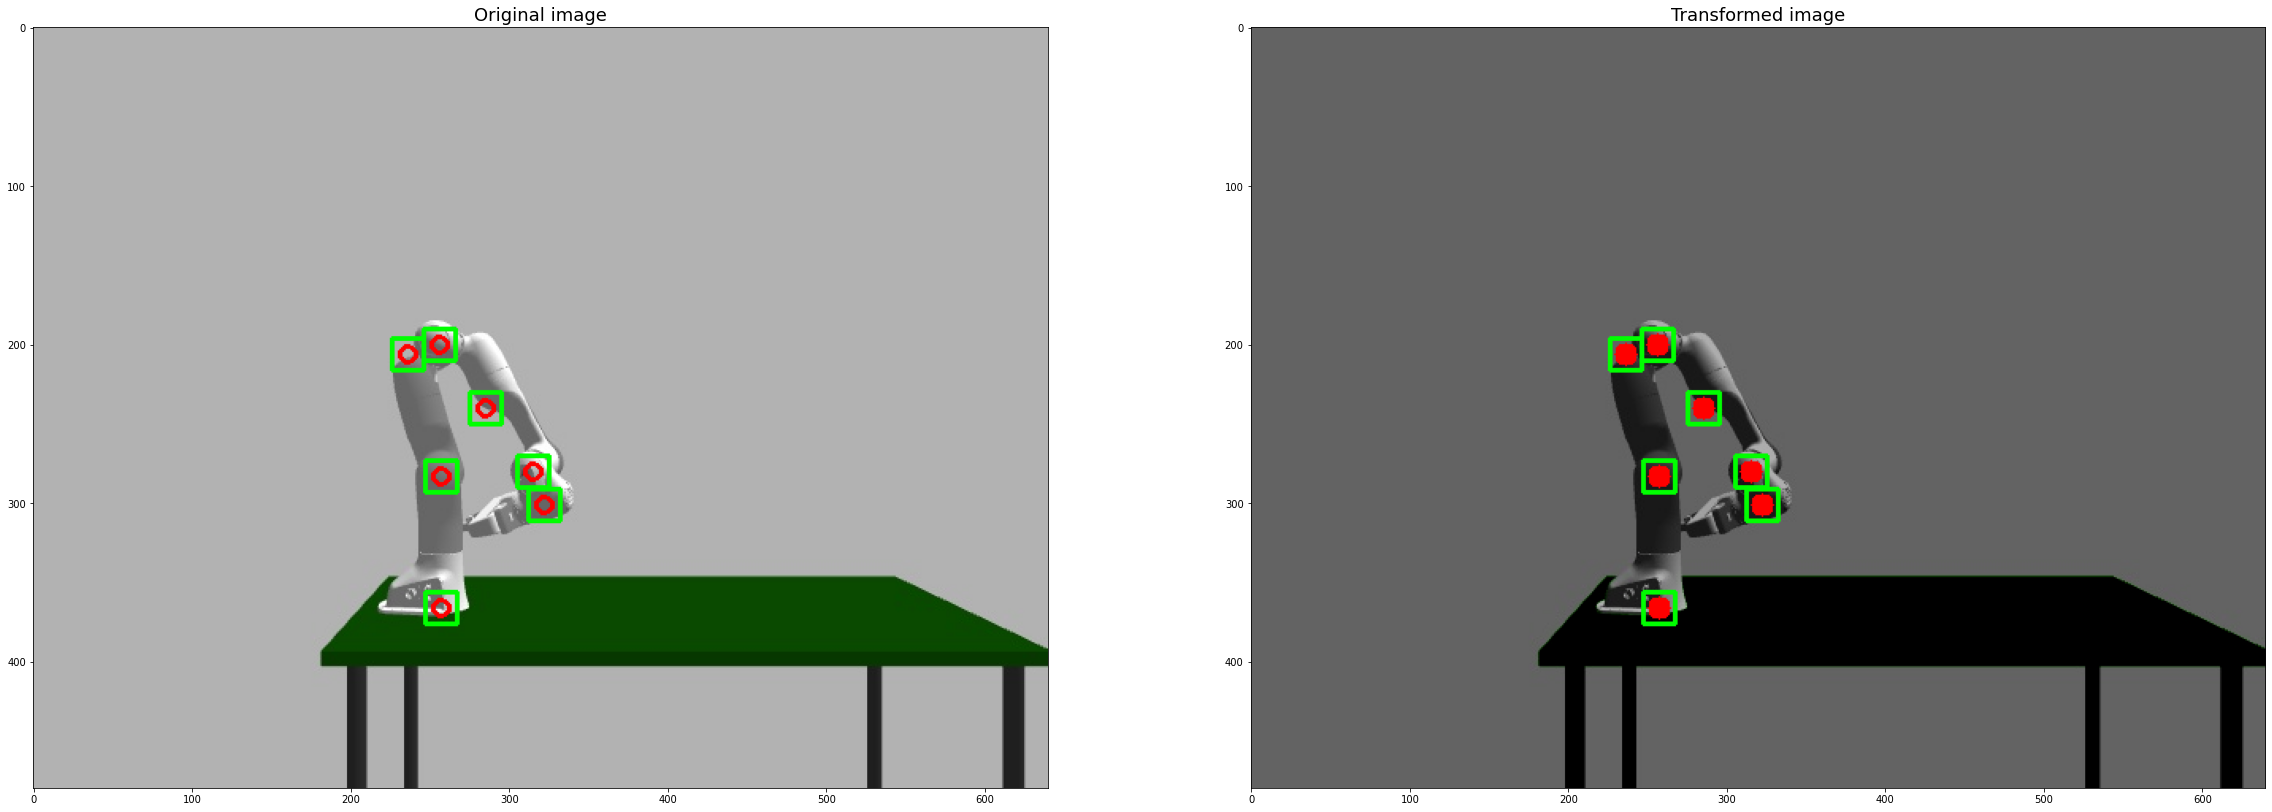

In [8]:
# function to visualize how the transformed data looks 

keypoints_classes_ids2names = {0: 'base_joint', 1: 'joint2', 2: 'joint3', 3: 'joint4', 4: 'joint5', 5: 'joint6',\
                              6:'joint7', 7:'joint8', 8:'panda_finger_1', 9:'panda_finger_2'}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for idx, kps in enumerate(keypoints):
        for kp in kps:
            image = cv2.circle(image.copy(), tuple(kp), 2, (255,0,0), 10)
#         image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)
        
        return image

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        print(keypoints_original)
        for idx, kps in enumerate(keypoints_original):
            print(idx)
            print(kps)
            for kp in kps:
                print(kp)
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 2)
#             image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
        
        return None
        
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
# for kps in batch1[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#     keypoints.append([kp[:2] for kp in [kps]])
    
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
# for kps in batch1[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#     keypoints_original.append([kp[:2] for kp in [kps]])
    
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

In [9]:
### made changes in the path ../.local/lib/python3.8/site-packages/albumentations/core/bbox_utils.py

'''def normalize_bbox(bbox: TBox, rows: int, cols: int) -> TBox:
    """Normalize coordinates of a bounding box. Divide x-coordinates by image width and y-coordinates
    by image height.

    Args:
        bbox: Denormalized bounding box `(x_min, y_min, x_max, y_max)`.
        rows: Image height.
        cols: Image width.

    Returns:
        Normalized bounding box `(x_min, y_min, x_max, y_max)`.

    Raises:
        ValueError: If rows or cols is less or equal zero

    """

    if rows <= 0:
        raise ValueError("Argument rows must be positive integer")
    if cols <= 0:
        raise ValueError("Argument cols must be positive integer")

    tail: Tuple[Any, ...]
    (x_min, y_min, x_max, y_max), tail = bbox[:4], tuple(bbox[4:])
    
    #x_min, x_max = x_min / cols, x_max / cols
    #y_min, y_max = y_min / rows, y_max / rows
    # next lines added by Jani
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(cols - 1, x_max)
    y_max = min(rows - 1, y_max)
    
    return cast(BoxType, (x_min/cols, y_min/rows, x_max/cols, y_max/rows) + tail)  # type: ignore
'''

### made changes in the path ../.local/lib/python3.8/site-packages/albumentations/core/keypoint_utils.py
'''def check_keypoint(kp, rows, cols):
    for name, value, size in zip(["x", "y"], kp[:2], [cols, rows]):
        value = min(max(0.0, value), size - 1)
        kp = tuple([value if i == idx else x for i, x in enumerate(kp)])
        if not 0 <= value < size:
            raise ValueError(
                "Expected {name} for keypoint {kp} "
                "to be in the range [0.0, {size}], got {value}.".format(kp=kp, name=name, value=value, size=size)
            )
    angle = kp[2]
    if not (0 <= angle < 2 * math.pi):
        raise ValueError(
            "Expected angle for keypoint {kp} to be in the range [0.0, 2 * pi], got {angle}.".format(kp=kp, angle=angle)
        )
    return kp

'''

'def check_keypoint(kp, rows, cols):\n    for name, value, size in zip(["x", "y"], kp[:2], [cols, rows]):\n        value = min(max(0.0, value), size - 1)\n        kp = tuple([value if i == idx else x for i, x in enumerate(kp)])\n        if not 0 <= value < size:\n            raise ValueError(\n                "Expected {name} for keypoint {kp} "\n                "to be in the range [0.0, {size}], got {value}.".format(kp=kp, name=name, value=value, size=size)\n            )\n    angle = kp[2]\n    if not (0 <= angle < 2 * math.pi):\n        raise ValueError(\n            "Expected angle for keypoint {kp} to be in the range [0.0, 2 * pi], got {angle}.".format(kp=kp, angle=angle)\n        )\n    return kp\n\n'

In [10]:
def get_model(num_keypoints, weights_path=None):
    
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(weights=False,
                                                                   weights_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 8, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

In [11]:
num_keypoints = 7
model = get_model(num_keypoints, weights_path=None)
model 

/home/jc-merlab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/jc-merlab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights_backbone=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, 

In [ ]:
total_keypoints = 7

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

split_folder_path = train_test_split(root_dir)

KEYPOINTS_FOLDER_TRAIN = split_folder_path +"/train" #train_test_split(root_dir) +"/train"
KEYPOINTS_FOLDER_VAL = split_folder_path +"/val"
KEYPOINTS_FOLDER_TEST = split_folder_path +"/test"

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
# dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=None, demo=False)
dataset_val = ClassDataset(KEYPOINTS_FOLDER_VAL, transform=None, demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

# batch_sizes = [3,2]
# epochs_lst = [30,50,100]

# batch_sizes = [3, 2, 1]
# epochs_lst = [25, 30]
batch_sizes = [1]
epochs_lst = [25, 30]

v = 2

for b_size in batch_sizes:
    for epochs in epochs_lst:
        data_loader_train = DataLoader(dataset_train, batch_size=b_size, shuffle=True, collate_fn=collate_fn)
        data_loader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn)
        data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

        model = get_model(num_keypoints = total_keypoints)
        model.to(device)

        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
        num_epochs = epochs

        for epoch in range(num_epochs):
            train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1000)
            lr_scheduler.step()
            
#             if epoch == 25 or epoch == 30 :
#                 PATH = f"/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_weights_ld_b{b_size}_e{epoch}_v{v}.pth"        
#                 torch.save(model, PATH)
#                 v+=1 
            
        
        PATH = f"/home/jc-merlab/Pictures/Data/trained_models/kprcnn_plan_b{b_size}_e{epochs}_v{v}_sim.pth"
            
            
        torch.save(model, PATH)
        
           
        


#     evaluate(model, data_loader_val, device)


/home/jc-merlab/Pictures/panda_data/panda_sim_vel/path_plan_kp_sim/split_folder_output


Copying files: 12000 files [00:00, 15496.89 files/s]


Epoch: [0]  [   0/4200]  eta: 0:40:01  lr: 0.000002  loss: 10.9729 (10.9729)  loss_classifier: 2.0410 (2.0410)  loss_box_reg: 0.1690 (0.1690)  loss_keypoint: 8.0501 (8.0501)  loss_objectness: 0.6916 (0.6916)  loss_rpn_box_reg: 0.0213 (0.0213)  time: 0.5718  data: 0.0039  max mem: 1121


In [ ]:
# Save model weights after training
# torch.save(model.state_dict(), 'keypointsrcnn_weights_120.pth')
# torch.save(model, '/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_weights_ld_b1_e30_v3.pth')
            
# torch.save(model, PATH)

In [ ]:
KEYPOINTS_FOLDER_VAL = parent_path + "split_folder_output-2023-07-14" +"/val"
dataset_val = ClassDataset(KEYPOINTS_FOLDER_VAL, transform=None, demo=False)
data_loader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn)
iterator = iter(data_loader_val)
len(data_loader_val)

In [ ]:
evaluate(model, data_loader_val, device)

In [ ]:
# weights_path = '/home/user/Workspace/WPI/Summer2023/ws/duc_repo/src/panda_test/data/trained_models/keypointsrcnn_weights_ld_b1_e25_v9.pth'
weights_path = PATH
model = torch.load(weights_path).to(device)
model.eval()

In [ ]:
data_iterator = iter(data_loader_val)
i = 1
while True:
    try:
        images, targets = next(data_iterator)
        images = list(img.to(device) for img in images)
        with torch.no_grad():
            outputs = model(images)
            images = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
            scores = outputs[0]['scores'].detach().cpu().numpy()

            high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
            post_nms_idxs = torchvision.ops.nms(outputs[0]['boxes'][high_scores_idxs], outputs[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)
            keypoints = []
            for kps in outputs[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
                keypoints.append([list(map(int, kp[:2])) for kp in kps])

            bboxes = []
            for bbox in outputs[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
                bboxes.append(list(map(int, bbox.tolist())))
            img = visualize(images, bboxes, keypoints)
#             cv2.imwrite("/home/jc-merlab/Pictures/Data/video_results_01/out_image_" + str(i) + ".jpg", img)
            cv2.imshow(f'image{i}', img)

            cv2.waitKey(0)
            cv2.destroyWindow(f'image{i}')

            
            i = i+1

            # Calculate loss and metrics for evaluation here.
    except StopIteration:
        break         
        


In [ ]:
weights_path = '/home/user/Workspace/WPI/Summer2023/ws/duc_repo/src/panda_test/data/trained_models/keypointsrcnn_weights_ld_b1_e25_v1.pth'
model = torch.load(weights_path).to(device)

images1, targets1 = next(iterator)
images2, targets2 = next(iterator)
images3, targets3 = next(iterator)
images4, targets4 = next(iterator)
# images, targets = next(iterator)

print(type(images1))


images1 = list(image1.to(device) for image1 in images1)
images2 = list(image2.to(device) for image2 in images2)
images3 = list(image3.to(device) for image3 in images3)
images4 = list(image4.to(device) for image4 in images4)
# images = list(image.to(device) for image in images)

print(type(images1))

with torch.no_grad():
    model.to(device)
    model.eval()
    output1 = model(images1)
    output2 = model(images2)
    output3 = model(images3)
    output4 = model(images4)
#     output = model(image)

# print("Predictions: \n", output1)



In [ ]:
print("Predictions: \n", output1)


In [ ]:
for i, (images, targets) in enumerate(data_loader_val)

In [ ]:
import cv2
import numpy as np
import torch
import time

weights_path = '/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_weights_ld_b1_e25_v2.pth'
model = torch.load(weights_path).to(device)
# model = get_model(num_keypoints=6, weights_path=weights_path)
# model.load_state_dict(torch.load('keypointsrcnn_weights.pth'))

model.to(device)
model.eval()

# print(type(model))
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('/home/jc-merlab/Pictures/Data/inference_data/test_video_3d.avi')
 
# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")
i = 0
print(type(i))
while(cap.isOpened()):
  # Capture frame-by-frame
    print(i)
    ret, frame = cap.read()
    if ret == True:        
#         img = cv2.imread(frame)
        image = Image.fromarray(frame)

        image = F.to_tensor(image).to(device)
        image.unsqueeze_(0)
        image = list(image)
    
        with torch.no_grad():
            model.to(device)
            model.eval()
            start = time.time(now)
            output = model(image)
            stop = time.time(now)
            print("time", (stop - start))

        image = (image[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
        scores = output[0]['scores'].detach().cpu().numpy()

        high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
        post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

        # Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
        # Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
        # Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

        keypoints = []
        for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            keypoints.append([list(map(int, kp[:2])) for kp in kps])

        bboxes = []
        for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            bboxes.append(list(map(int, bbox.tolist())))
        img = visualize(image, bboxes, keypoints)
        
        cv2.imwrite("/home/jc-merlab/Pictures/Data/video_results_01/out_image_" + str(i) + ".jpg", img)
    
    else:
        break
        
    i = i+1
    
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [ ]:
image1 = (images1[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores1 = output1[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores1 > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output1[0]['boxes'][high_scores_idxs], output1[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output1[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])
    
print(keypoints)

bboxes = []
for bbox in output1[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
image = visualize(image1, bboxes, keypoints)






In [ ]:
image2 = (images2[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output2[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output2[0]['boxes'][high_scores_idxs], output2[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output2[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

bboxes = []
for bbox in output2[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(image2, bboxes, keypoints)

In [ ]:
image3 = (images3[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores3 = output3[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output3[0]['boxes'][high_scores_idxs], output3[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output3[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

bboxes = []
for bbox in output3[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(image3, bboxes, keypoints)

In [ ]:
image4 = (images4[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores4 = output4[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output4[0]['boxes'][high_scores_idxs], output4[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output4[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

bboxes = []
for bbox in output4[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(image4, bboxes, keypoints)

In [ ]:
image = Image.open("/home/jc-merlab/428.jpg")
print(type(image))

image = F.to_tensor(image).to(device)
image.unsqueeze_(0)
print(image.shape)
image = list(image)
# print(type(images))
# images = list(image.to(device) for image in images)

with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(image)
    
    

In [ ]:
image = (image[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append(list(map(int, kps[0,0:2])))
#     keypoints.append([list(map(int, kp[:2])) for kp in kps])
keypoints_ = [x for _,x in sorted(zip(labels,keypoints))]

bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(image, bboxes, keypoints)

In [ ]:
import cv2
import numpy as np

weights_path = 'keypointsrcnn_weights.pth'
model = get_model(num_keypoints=6, weights_path=weights_path)
model.load_state_dict(torch.load('keypointsrcnn_weights.pth'))

model.to(device)

model.eval()

# print(type(model))
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('/home/jc-merlab/nov1_v1.avi')
 
# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")
i = 0
print(type(i))
while(cap.isOpened()):
  # Capture frame-by-frame
    print(i)
    ret, frame = cap.read()
    if ret == True:        
#         img = cv2.imread(frame)
        image = Image.fromarray(frame)

        image = F.to_tensor(image).to(device)
        image.unsqueeze_(0)
        image = list(image)
    
        with torch.no_grad():
            model.to(device)
            model.eval()
            output = model(image)

        image = (image[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
        scores = output[0]['scores'].detach().cpu().numpy()

        high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
        post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

        # Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
        # Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
        # Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

        keypoints = []
        for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            keypoints.append([list(map(int, kp[:2])) for kp in kps])

        bboxes = []
        for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            bboxes.append(list(map(int, bbox.tolist())))
        img = visualize(image, bboxes, keypoints)
        
        cv2.imwrite("/home/jc-merlab/Pictures/Data/video_results/out_image_" + str(i) + ".jpg", img)
        
    i = i+1
    
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [ ]:
import os
import moviepy.video.io.ImageSequenceClip
image_folder="/home/jc-merlab/Pictures/Data/video_results/"

fps=1

image_files = [os.path.join(image_folder,img)
               for img in os.listdir(image_folder)
               if img.endswith(".jpg")]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('my_video.mp4')

In [ ]:
2500//72

In [ ]:
import cv2
import numpy as np
import torch
import time

weights_path = '/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_weights_ld_b1_e25_v2.pth'
model = torch.load(weights_path).to(device)
# model = get_model(num_keypoints=6, weights_path=weights_path)
# model.load_state_dict(torch.load('keypointsrcnn_weights.pth'))

model.to(device)
model.eval()

# print(type(model))
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('/home/jc-merlab/Pictures/Data/inference_data/test_video_3d.avi')
 
# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")
i = 0
print(type(i))
while(cap.isOpened()):
  # Capture frame-by-frame
    print(i)
    ret, frame = cap.read()
    if ret == True:        
#         img = cv2.imread(frame)
        image = Image.fromarray(frame)

        image = F.to_tensor(image).to(device)
        image.unsqueeze_(0)
        image = list(image)
        
    
        with torch.no_grad():
            model.to(device)
            model.eval()
            start = time.time(now)
            output = model(image)
            stop = time.time(now)
            print("time", (stop - start))

        image = (image[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
        scores = output[0]['scores'].detach().cpu().numpy()

        high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
        post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

        # Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
        # Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
        # Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

        keypoints = []
        for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            keypoints.append([list(map(int, kp[:2])) for kp in kps])

        bboxes = []
        for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            bboxes.append(list(map(int, bbox.tolist())))
        img = visualize(image, bboxes, keypoints)
        
        labels = []
        for label in output[0]['labels'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            labels.append(label)
        keypoints_ = [x for _,x in sorted(zip(labels,keypoints))]
        
        
        cv2.imwrite("/home/jc-merlab/Pictures/Data/video_results_01/out_image_" + str(i) + ".jpg", img)
    
    else:
        break
        
    i = i+1
    
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [1]:
import cv2
import numpy as np
import torch
import time
import os
import json
import torch, torchvision
from PIL import Image
import torchvision.transforms as T
from torchvision.transforms import functional as F
import shutil

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

weights_path = '/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_weights_sim_b1_e25_v0.pth'
model = torch.load(weights_path).to(device)
# model = get_model(num_keypoints=6, weights_path=weights_path)
# model.load_state_dict(torch.load('keypointsrcnn_weights.pth'))

model.to(device)
model.eval()

# Specify input and output folders
input_folder = '/home/jc-merlab/Pictures/Data/occ_sim_append/'
output_frames_folder = '/home/jc-merlab/Pictures/Data/occ_sim_append_op/'
# output_json_folder = '/home/jc-merlab/Pictures/Data/keypoint_jsons'

# Check if output folders exist, create them if not
os.makedirs(output_frames_folder, exist_ok=True)
# os.makedirs(output_json_folder, exist_ok=True)

# Process images in the folder
i = 0
for filename in sorted(os.listdir(input_folder)):
    if filename.endswith('.jpg'):
        image_path = os.path.join(input_folder, filename)
        image = cv2.imread(image_path)  

        image = F.to_tensor(image).to(device)
        image.unsqueeze_(0)
        image = list(image)
        # print(type(images))
        # images = list(image.to(device) for image in images)

        with torch.no_grad():
            model.to(device)
            model.eval()
            output = model(image)
            image = (image[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
        scores = output[0]['scores'].detach().cpu().numpy()

        high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
        post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

        keypoints = []
        for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            keypoints.append(list(map(int, kps[0,0:2])))
            
        bboxes = []
        for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            bboxes.append(list(map(int, bbox.tolist())))
       
        labels = []
        for label in output[0]['labels'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            labels.append(label)
            
        keypoints_ = [x for _,x in sorted(zip(labels,keypoints))]
        print(keypoints_)
        bbox_ = [x for _,x in sorted(zip(labels,bboxes))]
        print(bbox_[3])
        
        # Modify the 4th keypoint as per the requirement
#         if len(keypoints_) >= 4 and len(bbox_) >= 4:
#             fourth_bbox = bbox_[3]
#             # Replace 4th keypoint with the top-left corner of the 4th bounding box
#             keypoints_[3] = [fourth_bbox[0], fourth_bbox[1]]
#             # Append the bottom-right corner of the 4th bounding box as a new keypoint
#             keypoints_.append([fourth_bbox[2], fourth_bbox[3]])
            
        print(keypoints_)

        # Generate JSON data
        image_filename_base = os.path.splitext(filename)[0]  # Remove '.jpg' extension
        json_data = {
            "id": i,
            "image_rgb": filename,  
            "keypoints": [[kp] for kp in keypoints_]
        }

        # Copy image to output folder
        output_image_path = os.path.join(output_frames_folder, filename)
        shutil.copyfile(image_path, output_image_path)

        # Save JSON with matching filename
        output_json_path = os.path.join(output_frames_folder, f"{image_filename_base}.json") 
        with open(output_json_path, 'w') as f:
            json.dump(json_data, f)

        i += 1

print("Processing complete!")

cuda
[[258, 367], [258, 283], [179, 297], [176, 277], [243, 205], [257, 222]]
[165, 267, 186, 287]
[[258, 367], [258, 283], [179, 297], [176, 277], [243, 205], [257, 222]]
[[258, 367], [258, 283], [180, 297], [176, 278], [251, 213], [265, 230]]
[166, 267, 186, 288]
[[258, 367], [258, 283], [180, 297], [176, 278], [251, 213], [265, 230]]
[[258, 367], [258, 283], [179, 297], [176, 278], [251, 213], [267, 226]]
[165, 267, 185, 287]
[[258, 367], [258, 283], [179, 297], [176, 278], [251, 213], [267, 226]]
[[258, 367], [258, 283], [180, 297], [176, 278], [251, 213], [270, 223]]
[165, 267, 185, 287]
[[258, 367], [258, 283], [180, 297], [176, 278], [251, 213], [270, 223]]
[[258, 367], [257, 283], [180, 297], [176, 278], [251, 213], [270, 222]]
[165, 267, 185, 287]
[[258, 367], [257, 283], [180, 297], [176, 278], [251, 213], [270, 222]]
[[258, 367], [258, 283], [179, 297], [176, 277], [250, 213], [270, 222]]
[165, 267, 186, 287]
[[258, 367], [258, 283], [179, 297], [176, 277], [250, 213], [270,

[[258, 367], [258, 283], [180, 297], [176, 277], [154, 181], [156, 159]]
[165, 267, 186, 287]
[[258, 367], [258, 283], [180, 297], [176, 277], [154, 181], [156, 159]]
[[258, 367], [258, 283], [180, 297], [176, 277], [154, 180], [154, 159]]
[165, 267, 186, 287]
[[258, 367], [258, 283], [180, 297], [176, 277], [154, 180], [154, 159]]
[[258, 367], [258, 283], [180, 297], [176, 277], [154, 180], [149, 159]]
[165, 267, 186, 287]
[[258, 367], [258, 283], [180, 297], [176, 277], [154, 180], [149, 159]]
[[258, 367], [258, 283], [180, 298], [176, 277], [136, 186], [126, 166]]
[165, 267, 186, 287]
[[258, 367], [258, 283], [180, 298], [176, 277], [136, 186], [126, 166]]
[[258, 367], [258, 283], [180, 298], [176, 277], [129, 190], [118, 171]]
[165, 267, 186, 287]
[[258, 367], [258, 283], [180, 298], [176, 277], [129, 190], [118, 171]]
[[258, 367], [258, 283], [180, 298], [176, 278], [129, 189], [126, 168]]
[165, 267, 186, 287]
[[258, 367], [258, 283], [180, 298], [176, 278], [129, 189], [126, 168]

[[258, 367], [258, 283], [180, 298], [176, 278], [77, 277], [61, 262]]
[165, 268, 185, 288]
[[258, 367], [258, 283], [180, 298], [176, 278], [77, 277], [61, 262]]
[[258, 367], [258, 283], [179, 298], [175, 278], [76, 277], [66, 259]]
[165, 268, 186, 288]
[[258, 367], [258, 283], [179, 298], [175, 278], [76, 277], [66, 259]]
[[258, 367], [258, 283], [179, 298], [176, 278], [76, 277], [69, 258]]
[165, 268, 186, 287]
[[258, 367], [258, 283], [179, 298], [176, 278], [76, 277], [69, 258]]
[[258, 367], [258, 283], [179, 298], [176, 278], [76, 277], [74, 257]]
[165, 268, 185, 288]
[[258, 367], [258, 283], [179, 298], [176, 278], [76, 277], [74, 257]]
[[258, 367], [258, 283], [180, 298], [176, 278], [77, 277], [77, 256]]
[165, 268, 185, 287]
[[258, 367], [258, 283], [180, 298], [176, 278], [77, 277], [77, 256]]
[[258, 367], [258, 283], [179, 298], [176, 278], [77, 277], [80, 256]]
[165, 267, 185, 287]
[[258, 367], [258, 283], [179, 298], [176, 278], [77, 277], [80, 256]]
[[258, 367], [258, 283

[[258, 367], [257, 283], [178, 275], [180, 255], [112, 183], [127, 168]]
[170, 245, 190, 265]
[[258, 367], [257, 283], [178, 275], [180, 255], [112, 183], [127, 168]]
[[258, 367], [257, 283], [178, 276], [180, 255], [112, 184], [125, 167]]
[169, 245, 190, 265]
[[258, 367], [257, 283], [178, 276], [180, 255], [112, 184], [125, 167]]
[[258, 367], [257, 283], [178, 275], [180, 255], [112, 184], [123, 165]]
[169, 245, 190, 265]
[[258, 367], [257, 283], [178, 275], [180, 255], [112, 184], [123, 165]]
[[258, 367], [258, 283], [178, 276], [180, 255], [112, 183], [118, 163]]
[170, 245, 190, 265]
[[258, 367], [258, 283], [178, 276], [180, 255], [112, 183], [118, 163]]
[[258, 367], [258, 283], [178, 276], [180, 255], [111, 183], [116, 163]]
[170, 245, 190, 265]
[[258, 367], [258, 283], [178, 276], [180, 255], [111, 183], [116, 163]]
[[258, 367], [258, 283], [178, 276], [180, 255], [111, 184], [109, 162]]
[169, 245, 190, 265]
[[258, 367], [258, 283], [178, 276], [180, 255], [111, 184], [109, 162]

[[258, 367], [258, 283], [178, 276], [180, 256], [209, 161], [219, 141]]
[169, 245, 190, 266]
[[258, 367], [258, 283], [178, 276], [180, 256], [209, 161], [219, 141]]
[[258, 367], [258, 283], [178, 276], [180, 256], [209, 161], [214, 140]]
[170, 245, 190, 266]
[[258, 367], [258, 283], [178, 276], [180, 256], [209, 161], [214, 140]]
[[258, 367], [258, 283], [178, 277], [180, 256], [232, 171], [244, 153]]
[169, 245, 190, 266]
[[258, 367], [258, 283], [178, 277], [180, 256], [232, 171], [244, 153]]
[[258, 367], [258, 283], [178, 276], [180, 256], [232, 172], [247, 155]]
[169, 245, 190, 266]
[[258, 367], [258, 283], [178, 276], [180, 256], [232, 172], [247, 155]]
[[258, 367], [258, 283], [178, 276], [180, 256], [232, 172], [250, 159]]
[169, 245, 190, 266]
[[258, 367], [258, 283], [178, 276], [180, 256], [232, 172], [250, 159]]
[[258, 367], [258, 283], [178, 276], [180, 256], [232, 172], [252, 162]]
[169, 246, 189, 266]
[[258, 367], [258, 283], [178, 276], [180, 256], [232, 172], [252, 162]

[[258, 367], [258, 283], [183, 253], [191, 234], [281, 193], [300, 204]]
[181, 224, 201, 244]
[[258, 367], [258, 283], [183, 253], [191, 234], [281, 193], [300, 204]]
[[258, 367], [258, 283], [183, 253], [191, 234], [281, 193], [297, 207]]
[181, 224, 201, 244]
[[258, 367], [258, 283], [183, 253], [191, 234], [281, 193], [297, 207]]
[[258, 367], [258, 283], [183, 253], [191, 234], [281, 193], [295, 209]]
[181, 224, 201, 244]
[[258, 367], [258, 283], [183, 253], [191, 234], [281, 193], [295, 209]]
[[258, 367], [258, 283], [183, 253], [191, 234], [281, 193], [292, 211]]
[181, 224, 201, 244]
[[258, 367], [258, 283], [183, 253], [191, 234], [281, 193], [292, 211]]
[[258, 367], [258, 283], [183, 253], [191, 234], [281, 193], [288, 213]]
[181, 224, 201, 244]
[[258, 367], [258, 283], [183, 253], [191, 234], [281, 193], [288, 213]]
[[258, 367], [258, 283], [183, 253], [191, 234], [267, 171], [279, 189]]
[181, 224, 201, 244]
[[258, 367], [258, 283], [183, 253], [191, 234], [267, 171], [279, 189]

[[258, 367], [258, 283], [183, 254], [191, 234], [172, 137], [191, 126]]
[181, 224, 201, 244]
[[258, 367], [258, 283], [183, 254], [191, 234], [172, 137], [191, 126]]
[[258, 367], [258, 283], [184, 254], [191, 235], [172, 137], [189, 124]]
[181, 224, 201, 244]
[[258, 367], [258, 283], [184, 254], [191, 235], [172, 137], [189, 124]]
[[258, 367], [258, 283], [183, 254], [192, 235], [172, 137], [187, 121]]
[181, 224, 201, 244]
[[258, 367], [258, 283], [183, 254], [192, 235], [172, 137], [187, 121]]
[[258, 367], [258, 283], [183, 254], [191, 235], [171, 137], [183, 118]]
[181, 224, 201, 244]
[[258, 367], [258, 283], [183, 254], [191, 235], [171, 137], [183, 118]]
[[258, 367], [258, 283], [183, 254], [191, 235], [172, 137], [179, 116]]
[181, 224, 201, 245]
[[258, 367], [258, 283], [183, 254], [191, 235], [172, 137], [179, 116]]
[[258, 367], [258, 283], [183, 254], [191, 235], [172, 137], [175, 115]]
[181, 224, 201, 245]
[[258, 367], [258, 283], [183, 254], [191, 235], [172, 137], [175, 115]

[[258, 367], [258, 283], [194, 234], [207, 218], [123, 163], [105, 150]]
[196, 208, 217, 228]
[[258, 367], [258, 283], [194, 234], [207, 218], [123, 163], [105, 150]]
[[258, 367], [258, 283], [194, 233], [207, 218], [124, 163], [108, 147]]
[196, 208, 217, 228]
[[258, 367], [258, 283], [194, 233], [207, 218], [124, 163], [108, 147]]
[[258, 367], [258, 283], [194, 233], [207, 218], [125, 162], [111, 145]]
[196, 208, 217, 227]
[[258, 367], [258, 283], [194, 233], [207, 218], [125, 162], [111, 145]]
[[258, 367], [258, 283], [194, 234], [207, 218], [124, 162], [115, 143]]
[197, 207, 217, 228]
[[258, 367], [258, 283], [194, 234], [207, 218], [124, 162], [115, 143]]
[[258, 367], [258, 283], [194, 234], [207, 218], [124, 161], [119, 142]]
[196, 208, 217, 228]
[[258, 367], [258, 283], [194, 234], [207, 218], [124, 161], [119, 142]]
[[258, 367], [257, 283], [194, 234], [207, 218], [124, 163], [123, 142]]
[196, 207, 217, 227]
[[258, 367], [257, 283], [194, 234], [207, 218], [124, 163], [123, 142]

[[258, 367], [258, 283], [194, 235], [206, 218], [214, 120], [235, 118]]
[196, 208, 217, 228]
[[258, 367], [258, 283], [194, 235], [206, 218], [214, 120], [235, 118]]
[[258, 367], [258, 283], [194, 235], [206, 218], [214, 119], [236, 121]]
[196, 208, 217, 228]
[[258, 367], [258, 283], [194, 235], [206, 218], [214, 119], [236, 121]]
[[258, 367], [257, 283], [194, 235], [206, 218], [214, 120], [235, 125]]
[196, 208, 217, 228]
[[258, 367], [257, 283], [194, 235], [206, 218], [214, 120], [235, 125]]
[[258, 367], [258, 283], [194, 235], [207, 218], [235, 124], [255, 133]]
[196, 208, 217, 228]
[[258, 367], [258, 283], [194, 235], [207, 218], [235, 124], [255, 133]]
[[258, 367], [258, 283], [194, 235], [206, 218], [240, 126], [260, 133]]
[196, 208, 216, 228]
[[258, 367], [258, 283], [194, 235], [206, 218], [240, 126], [260, 133]]
[[258, 367], [258, 283], [194, 235], [207, 218], [240, 125], [261, 131]]
[196, 208, 216, 228]
[[258, 367], [258, 283], [194, 235], [207, 218], [240, 125], [261, 131]

[[258, 367], [258, 283], [194, 235], [206, 218], [305, 204], [322, 218]]
[196, 208, 216, 228]
[[258, 367], [258, 283], [194, 235], [206, 218], [305, 204], [322, 218]]
[[258, 367], [258, 283], [194, 235], [206, 218], [305, 204], [323, 215]]
[196, 208, 216, 228]
[[258, 367], [258, 283], [194, 235], [206, 218], [305, 204], [323, 215]]
[[258, 367], [258, 283], [194, 235], [206, 218], [305, 204], [325, 212]]
[196, 208, 216, 228]
[[258, 367], [258, 283], [194, 235], [206, 218], [305, 204], [325, 212]]
[[258, 367], [258, 283], [194, 235], [206, 218], [305, 203], [326, 209]]
[196, 208, 216, 228]
[[258, 367], [258, 283], [194, 235], [206, 218], [305, 203], [326, 209]]
[[258, 367], [258, 283], [194, 235], [206, 218], [305, 204], [327, 206]]
[196, 208, 216, 228]
[[258, 367], [258, 283], [194, 235], [206, 218], [305, 204], [327, 206]]
[[258, 367], [257, 283], [194, 235], [206, 218], [305, 204], [327, 201]]
[196, 208, 216, 228]
[[258, 367], [257, 283], [194, 235], [206, 218], [305, 204], [327, 201]

[[258, 367], [258, 283], [211, 218], [228, 206], [320, 170], [336, 154]]
[219, 196, 238, 216]
[[258, 367], [258, 283], [211, 218], [228, 206], [320, 170], [336, 154]]
[[258, 367], [258, 282], [211, 218], [228, 206], [320, 170], [338, 157]]
[218, 196, 238, 216]
[[258, 367], [258, 282], [211, 218], [228, 206], [320, 170], [338, 157]]
[[258, 367], [258, 283], [211, 218], [228, 206], [321, 170], [340, 160]]
[219, 196, 238, 216]
[[258, 367], [258, 283], [211, 218], [228, 206], [321, 170], [340, 160]]
[[258, 367], [258, 283], [211, 218], [228, 206], [321, 170], [342, 163]]
[219, 196, 238, 216]
[[258, 367], [258, 283], [211, 218], [228, 206], [321, 170], [342, 163]]
[[258, 367], [258, 283], [211, 218], [228, 206], [321, 170], [342, 168]]
[219, 196, 238, 216]
[[258, 367], [258, 283], [211, 218], [228, 206], [321, 170], [342, 168]]
[[258, 367], [258, 283], [211, 218], [228, 206], [321, 170], [343, 171]]
[219, 196, 238, 216]
[[258, 367], [258, 283], [211, 218], [228, 206], [321, 170], [343, 171]

[[258, 367], [258, 283], [211, 218], [229, 206], [243, 107], [262, 98]]
[218, 196, 238, 216]
[[258, 367], [258, 283], [211, 218], [229, 206], [243, 107], [262, 98]]
[[258, 367], [258, 283], [211, 218], [229, 206], [216, 107], [233, 94]]
[218, 196, 238, 216]
[[258, 367], [258, 283], [211, 218], [229, 206], [216, 107], [233, 94]]
[[258, 367], [258, 283], [211, 218], [229, 206], [217, 107], [230, 90]]
[218, 196, 238, 216]
[[258, 367], [258, 283], [211, 218], [229, 206], [217, 107], [230, 90]]
[[258, 367], [258, 283], [211, 218], [229, 206], [216, 107], [227, 88]]
[218, 195, 238, 216]
[[258, 367], [258, 283], [211, 218], [229, 206], [216, 107], [227, 88]]
[[258, 367], [258, 283], [211, 218], [229, 206], [216, 107], [223, 87]]
[218, 196, 239, 216]
[[258, 367], [258, 283], [211, 218], [229, 206], [216, 107], [223, 87]]
[[258, 367], [258, 283], [211, 218], [229, 206], [217, 107], [220, 86]]
[218, 196, 238, 216]
[[258, 367], [258, 283], [211, 218], [229, 206], [217, 107], [220, 86]]
[[258, 367

[[258, 367], [258, 283], [232, 207], [251, 201], [242, 102], [235, 80]]
[241, 190, 262, 211]
[[258, 367], [258, 283], [232, 207], [251, 201], [242, 102], [235, 80]]
[[258, 367], [258, 283], [232, 207], [251, 201], [242, 102], [232, 82]]
[241, 190, 262, 211]
[[258, 367], [258, 283], [232, 207], [251, 201], [242, 102], [232, 82]]
[[258, 367], [258, 283], [232, 207], [251, 201], [242, 102], [228, 83]]
[241, 190, 262, 211]
[[258, 367], [258, 283], [232, 207], [251, 201], [242, 102], [228, 83]]
[[258, 367], [258, 283], [232, 207], [251, 201], [242, 102], [226, 85]]
[241, 190, 262, 211]
[[258, 367], [258, 283], [232, 207], [251, 201], [242, 102], [226, 85]]
[[258, 367], [258, 283], [232, 207], [252, 201], [268, 103], [257, 83]]
[241, 190, 262, 211]
[[258, 367], [258, 283], [232, 207], [252, 201], [268, 103], [257, 83]]
[[258, 367], [258, 283], [232, 207], [252, 201], [269, 103], [260, 82]]
[241, 190, 262, 211]
[[258, 367], [258, 283], [232, 207], [252, 201], [269, 103], [260, 82]]
[[258, 367

[[258, 367], [258, 283], [233, 207], [252, 201], [347, 170], [367, 162]]
[242, 190, 262, 211]
[[258, 367], [258, 283], [233, 207], [252, 201], [347, 170], [367, 162]]
[[258, 367], [258, 283], [233, 207], [252, 201], [347, 170], [368, 166]]
[242, 191, 262, 211]
[[258, 367], [258, 283], [233, 207], [252, 201], [347, 170], [368, 166]]
[[258, 367], [258, 283], [232, 207], [252, 201], [347, 170], [369, 170]]
[242, 191, 262, 211]
[[258, 367], [258, 283], [232, 207], [252, 201], [347, 170], [369, 170]]
[[258, 367], [258, 283], [232, 207], [252, 201], [347, 170], [369, 173]]
[242, 190, 262, 211]
[[258, 367], [258, 283], [232, 207], [252, 201], [347, 170], [369, 173]]
[[258, 367], [258, 283], [232, 207], [252, 201], [347, 170], [367, 178]]
[242, 190, 262, 211]
[[258, 367], [258, 283], [232, 207], [252, 201], [347, 170], [367, 178]]
[[258, 367], [258, 283], [232, 207], [252, 200], [346, 170], [366, 180]]
[242, 190, 262, 211]
[[258, 367], [258, 283], [232, 207], [252, 200], [346, 170], [366, 180]

[[258, 367], [258, 283], [256, 203], [277, 203], [326, 289], [323, 310]]
[267, 192, 287, 212]
[[258, 367], [258, 283], [256, 203], [277, 203], [326, 289], [323, 310]]
[[258, 367], [258, 283], [256, 203], [277, 203], [326, 289], [327, 311]]
[267, 192, 287, 212]
[[258, 367], [258, 283], [256, 203], [277, 203], [326, 289], [327, 311]]
[[258, 367], [258, 283], [256, 203], [277, 203], [326, 289], [331, 310]]
[267, 192, 287, 212]
[[258, 367], [258, 283], [256, 203], [277, 203], [326, 289], [331, 310]]
[[258, 367], [258, 283], [256, 203], [277, 203], [326, 289], [334, 310]]
[267, 192, 287, 212]
[[258, 367], [258, 283], [256, 203], [277, 203], [326, 289], [334, 310]]
[[258, 367], [258, 283], [256, 203], [277, 203], [326, 289], [336, 308]]
[267, 192, 287, 212]
[[258, 367], [258, 283], [256, 203], [277, 203], [326, 289], [336, 308]]
[[258, 367], [258, 283], [256, 203], [277, 203], [326, 289], [340, 306]]
[267, 192, 287, 212]
[[258, 367], [258, 283], [256, 203], [277, 203], [326, 289], [340, 306]

[[258, 367], [258, 283], [257, 203], [278, 203], [377, 204], [394, 190]]
[268, 193, 288, 213]
[[258, 367], [258, 283], [257, 203], [278, 203], [377, 204], [394, 190]]
[[258, 367], [258, 283], [257, 203], [278, 203], [377, 204], [391, 188]]
[268, 193, 288, 213]
[[258, 367], [258, 283], [257, 203], [278, 203], [377, 204], [391, 188]]
[[258, 367], [258, 283], [257, 203], [278, 203], [374, 177], [384, 158]]
[268, 193, 288, 213]
[[258, 367], [258, 283], [257, 203], [278, 203], [374, 177], [384, 158]]
[[258, 367], [258, 283], [257, 203], [278, 203], [374, 178], [386, 160]]
[268, 193, 288, 213]
[[258, 367], [258, 283], [257, 203], [278, 203], [374, 178], [386, 160]]
[[258, 367], [258, 283], [258, 203], [278, 203], [374, 178], [390, 162]]
[268, 193, 288, 213]
[[258, 367], [258, 283], [258, 203], [278, 203], [374, 178], [390, 162]]
[[258, 367], [258, 283], [257, 203], [278, 203], [374, 179], [392, 165]]
[268, 193, 288, 213]
[[258, 367], [258, 283], [257, 203], [278, 203], [374, 179], [392, 165]

[[258, 367], [258, 283], [258, 203], [279, 203], [305, 107], [315, 87]]
[269, 193, 289, 213]
[[258, 367], [258, 283], [258, 203], [279, 203], [305, 107], [315, 87]]
[[258, 367], [258, 283], [258, 203], [279, 203], [306, 108], [317, 89]]
[269, 193, 289, 213]
[[258, 367], [258, 283], [258, 203], [279, 203], [306, 108], [317, 89]]
[[258, 367], [258, 283], [258, 203], [279, 203], [306, 108], [320, 91]]
[269, 193, 289, 213]
[[258, 367], [258, 283], [258, 203], [279, 203], [306, 108], [320, 91]]
[[258, 367], [258, 283], [258, 203], [279, 203], [306, 108], [323, 96]]
[269, 193, 289, 213]
[[258, 367], [258, 283], [258, 203], [279, 203], [306, 108], [323, 96]]
[[258, 367], [258, 283], [259, 203], [279, 203], [306, 108], [325, 99]]
[269, 193, 289, 213]
[[258, 367], [258, 283], [259, 203], [279, 203], [306, 108], [325, 99]]
[[258, 367], [258, 283], [258, 203], [279, 203], [283, 104], [300, 92]]
[269, 193, 289, 213]
[[258, 367], [258, 283], [258, 203], [279, 203], [283, 104], [300, 92]]
[[258, 367

[[258, 367], [258, 283], [282, 207], [302, 214], [391, 170], [413, 169]]
[292, 203, 312, 223]
[[258, 367], [258, 283], [282, 207], [302, 214], [391, 170], [413, 169]]
[[258, 367], [258, 283], [282, 207], [302, 214], [392, 170], [413, 165]]
[292, 203, 312, 223]
[[258, 367], [258, 283], [282, 207], [302, 214], [392, 170], [413, 165]]
[[258, 367], [258, 283], [282, 207], [302, 214], [391, 171], [412, 162]]
[292, 203, 312, 224]
[[258, 367], [258, 283], [282, 207], [302, 214], [391, 171], [412, 162]]
[[258, 367], [258, 283], [282, 207], [302, 214], [392, 171], [410, 158]]
[292, 203, 312, 224]
[[258, 367], [258, 283], [282, 207], [302, 214], [392, 171], [410, 158]]
[[258, 367], [258, 283], [282, 207], [302, 214], [392, 171], [409, 156]]
[292, 203, 312, 224]
[[258, 367], [258, 283], [282, 207], [302, 214], [392, 171], [409, 156]]
[[258, 367], [258, 283], [282, 207], [302, 214], [392, 171], [405, 154]]
[292, 203, 312, 224]
[[258, 367], [258, 283], [282, 207], [302, 214], [392, 171], [405, 154]

[[258, 367], [258, 283], [284, 207], [303, 214], [364, 293], [386, 295]]
[293, 204, 313, 224]
[[258, 367], [258, 283], [284, 207], [303, 214], [364, 293], [386, 295]]
[[258, 367], [258, 283], [284, 207], [303, 214], [364, 293], [384, 299]]
[293, 204, 313, 224]
[[258, 367], [258, 283], [284, 207], [303, 214], [364, 293], [384, 299]]
[[258, 367], [258, 283], [284, 207], [303, 214], [363, 293], [384, 302]]
[293, 204, 313, 224]
[[258, 367], [258, 283], [284, 207], [303, 214], [363, 293], [384, 302]]
[[258, 367], [258, 283], [284, 207], [303, 214], [363, 293], [382, 306]]
[293, 204, 313, 224]
[[258, 367], [258, 283], [284, 207], [303, 214], [363, 293], [382, 306]]
[[258, 367], [258, 283], [284, 207], [303, 214], [364, 293], [380, 309]]
[293, 204, 313, 224]
[[258, 367], [258, 283], [284, 207], [303, 214], [364, 293], [380, 309]]
[[258, 367], [258, 283], [284, 207], [303, 214], [363, 293], [377, 311]]
[293, 204, 313, 224]
[[258, 367], [258, 283], [284, 207], [303, 214], [363, 293], [377, 311]

[[258, 367], [258, 283], [281, 206], [301, 212], [348, 299], [366, 310]]
[290, 202, 311, 222]
[[258, 367], [258, 283], [281, 206], [301, 212], [348, 299], [366, 310]]
[[258, 367], [258, 283], [281, 206], [301, 212], [347, 300], [364, 314]]
[290, 202, 311, 223]
[[258, 367], [258, 283], [281, 206], [301, 212], [347, 300], [364, 314]]
[[258, 367], [258, 283], [281, 206], [301, 212], [347, 299], [362, 316]]
[290, 202, 311, 223]
[[258, 367], [258, 283], [281, 206], [301, 212], [347, 299], [362, 316]]
[[258, 367], [258, 283], [281, 206], [301, 213], [368, 284], [387, 297]]
[290, 202, 310, 222]
[[258, 367], [258, 283], [281, 206], [301, 213], [368, 284], [387, 297]]
[[258, 367], [258, 283], [281, 206], [301, 213], [369, 285], [389, 294]]
[290, 202, 310, 222]
[[258, 367], [258, 283], [281, 206], [301, 213], [369, 285], [389, 294]]
[[258, 367], [258, 283], [281, 207], [301, 213], [369, 285], [391, 291]]
[290, 202, 310, 222]
[[258, 367], [258, 283], [281, 207], [301, 213], [369, 285], [391, 291]

[[258, 367], [258, 283], [282, 207], [302, 213], [398, 191], [410, 172]]
[291, 203, 311, 223]
[[258, 367], [258, 283], [282, 207], [302, 213], [398, 191], [410, 172]]
[[258, 367], [258, 283], [282, 207], [302, 213], [399, 191], [406, 170]]
[292, 203, 312, 223]
[[258, 367], [258, 283], [282, 207], [302, 213], [399, 191], [406, 170]]
[[258, 367], [258, 283], [282, 207], [302, 214], [398, 191], [403, 170]]
[292, 203, 312, 223]
[[258, 367], [258, 283], [282, 207], [302, 214], [398, 191], [403, 170]]
[[258, 367], [258, 283], [282, 207], [302, 214], [399, 191], [397, 169]]
[292, 203, 311, 223]
[[258, 367], [258, 283], [282, 207], [302, 214], [399, 191], [397, 169]]
[[258, 367], [258, 283], [282, 207], [302, 213], [399, 191], [394, 169]]
[291, 203, 311, 223]
[[258, 367], [258, 283], [282, 207], [302, 213], [399, 191], [394, 169]]
[[258, 367], [258, 283], [282, 207], [302, 213], [398, 191], [390, 171]]
[291, 203, 311, 223]
[[258, 367], [258, 283], [282, 207], [302, 213], [398, 191], [390, 171]

[[258, 367], [258, 283], [304, 218], [321, 230], [376, 148], [357, 138]]
[311, 220, 330, 240]
[[258, 367], [258, 283], [304, 218], [321, 230], [376, 148], [357, 138]]
[[258, 367], [258, 283], [304, 218], [321, 230], [376, 149], [359, 136]]
[311, 220, 330, 240]
[[258, 367], [258, 283], [304, 218], [321, 230], [376, 149], [359, 136]]
[[258, 367], [258, 283], [304, 218], [321, 230], [376, 148], [363, 133]]
[311, 220, 330, 240]
[[258, 367], [258, 283], [304, 218], [321, 230], [376, 148], [363, 133]]
[[258, 367], [258, 283], [304, 218], [321, 230], [377, 148], [364, 130]]
[311, 219, 331, 240]
[[258, 367], [258, 283], [304, 218], [321, 230], [377, 148], [364, 130]]
[[258, 367], [258, 283], [303, 218], [321, 230], [377, 148], [369, 128]]
[311, 220, 330, 240]
[[258, 367], [258, 283], [303, 218], [321, 230], [377, 148], [369, 128]]
[[258, 367], [258, 283], [303, 218], [321, 230], [376, 148], [372, 127]]
[311, 220, 330, 240]
[[258, 367], [258, 283], [303, 218], [321, 230], [376, 148], [372, 127]

[[258, 367], [258, 283], [305, 219], [322, 231], [420, 244], [441, 235]]
[312, 221, 331, 241]
[[258, 367], [258, 283], [305, 219], [322, 231], [420, 244], [441, 235]]
[[258, 367], [258, 283], [305, 219], [322, 231], [420, 244], [443, 238]]
[312, 221, 332, 241]
[[258, 367], [258, 283], [305, 219], [322, 231], [420, 244], [443, 238]]
[[258, 367], [258, 283], [305, 219], [322, 231], [420, 244], [443, 242]]
[312, 221, 332, 241]
[[258, 367], [258, 283], [305, 219], [322, 231], [420, 244], [443, 242]]
[[258, 367], [258, 283], [305, 219], [322, 231], [417, 260], [439, 264]]
[312, 221, 332, 241]
[[258, 367], [258, 283], [305, 219], [322, 231], [417, 260], [439, 264]]
[[258, 367], [258, 283], [306, 219], [322, 231], [414, 269], [436, 272]]
[312, 221, 332, 241]
[[258, 367], [258, 283], [306, 219], [322, 231], [414, 269], [436, 272]]
[[258, 367], [258, 283], [305, 219], [322, 231], [413, 270], [436, 268]]
[312, 221, 332, 241]
[[258, 367], [258, 283], [305, 219], [322, 231], [413, 270], [436, 268]

[[258, 367], [258, 283], [296, 213], [314, 223], [341, 319], [341, 340]]
[304, 213, 324, 233]
[[258, 367], [258, 283], [296, 213], [314, 223], [341, 319], [341, 340]]
[[258, 367], [258, 283], [296, 213], [314, 223], [341, 318], [345, 341]]
[304, 213, 324, 233]
[[258, 367], [258, 283], [296, 213], [314, 223], [341, 318], [345, 341]]
[[258, 367], [258, 283], [296, 213], [314, 223], [341, 317], [347, 340]]
[304, 213, 324, 233]
[[258, 367], [258, 283], [296, 213], [314, 223], [341, 317], [347, 340]]
[[258, 367], [258, 283], [296, 213], [314, 223], [340, 317], [351, 338]]
[304, 213, 324, 233]
[[258, 367], [258, 283], [296, 213], [314, 223], [340, 317], [351, 338]]
[[258, 367], [258, 283], [296, 213], [315, 223], [341, 318], [350, 338]]
[304, 213, 324, 233]
[[258, 367], [258, 283], [296, 213], [315, 223], [341, 318], [350, 338]]
[[258, 367], [258, 283], [296, 213], [315, 223], [340, 318], [350, 338]]
[304, 213, 324, 233]
[[258, 367], [258, 283], [296, 213], [315, 223], [340, 318], [350, 338]

[[258, 367], [258, 283], [309, 223], [325, 236], [374, 321], [374, 341]]
[315, 226, 335, 246]
[[258, 367], [258, 283], [309, 223], [325, 236], [374, 321], [374, 341]]
[[258, 367], [258, 283], [310, 222], [325, 236], [374, 321], [372, 340]]
[315, 226, 335, 246]
[[258, 367], [258, 283], [310, 222], [325, 236], [374, 321], [372, 340]]
[[258, 367], [258, 283], [310, 222], [325, 236], [375, 322], [371, 339]]
[315, 226, 335, 246]
[[258, 367], [258, 283], [310, 222], [325, 236], [375, 322], [371, 339]]
[[258, 367], [258, 283], [310, 222], [325, 236], [375, 321], [365, 336]]
[315, 226, 335, 246]
[[258, 367], [258, 283], [310, 222], [325, 236], [375, 321], [365, 336]]
[[258, 367], [258, 283], [309, 222], [325, 236], [375, 321], [363, 333]]
[315, 226, 335, 246]
[[258, 367], [258, 283], [309, 222], [325, 236], [375, 321], [363, 333]]
[[258, 367], [258, 283], [309, 222], [325, 236], [375, 322], [362, 331]]
[315, 226, 335, 246]
[[258, 367], [258, 283], [309, 222], [325, 236], [375, 322], [362, 331]

[[258, 367], [258, 283], [311, 224], [326, 238], [425, 239], [421, 254]]
[316, 227, 336, 247]
[[258, 367], [258, 283], [311, 224], [326, 238], [425, 239], [421, 254]]
[[258, 367], [258, 283], [311, 223], [326, 238], [423, 214], [422, 230]]
[316, 227, 336, 247]
[[258, 367], [258, 283], [311, 223], [326, 238], [423, 214], [422, 230]]
[[258, 367], [258, 283], [311, 223], [326, 238], [423, 213], [426, 228]]
[316, 227, 336, 247]
[[258, 367], [258, 283], [311, 223], [326, 238], [423, 213], [426, 228]]
[[258, 367], [258, 283], [310, 224], [326, 238], [422, 213], [429, 228]]
[316, 227, 336, 247]
[[258, 367], [258, 283], [310, 224], [326, 238], [422, 213], [429, 228]]
[[258, 367], [258, 283], [311, 224], [326, 238], [422, 214], [432, 227]]
[316, 227, 336, 247]
[[258, 367], [258, 283], [311, 224], [326, 238], [422, 214], [432, 227]]
[[258, 367], [258, 283], [311, 223], [326, 238], [422, 213], [435, 225]]
[316, 227, 336, 247]
[[258, 367], [258, 283], [311, 223], [326, 238], [422, 213], [435, 225]

In [17]:
import os
import cv2
import torch
import torchvision
import numpy as np
import json
import shutil
from torchvision.transforms import functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

weights_path = '/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_weights_sim_b1_e25_v0.pth'
model = torch.load(weights_path).to(device)
# model = get_model(num_keypoints=6, weights_path=weights_path)
# model.load_state_dict(torch.load('keypointsrcnn_weights.pth'))

model.to(device)
model.eval()

# Assuming the necessary imports are done
# Assuming the model is loaded and device is set as in your initial code

# Specify input and output folders
input_folder = '/home/jc-merlab/Pictures/Data/occ_test_data/'
output_frames_folder = '/home/jc-merlab/Pictures/Data/occ_sim_append_op/'

# Check if output folders exist, create them if not
os.makedirs(output_frames_folder, exist_ok=True)

def load_ground_truth(json_path):
    """
    Load ground truth keypoints from the corresponding JSON file.
    """
    with open(json_path, 'r') as f:
        data = json.load(f)
    ground_truth_keypoints = [[int(kp[0][0]), int(kp[0][1])] for kp in data['keypoints']]  # Convert coordinates to integers
    return ground_truth_keypoints

# Process images in the folder
i = 0
for filename in sorted(os.listdir(input_folder)):
    if filename.endswith('.jpg'):
        image_path = os.path.join(input_folder, filename)
        image = cv2.imread(image_path)

        tensor_image = F.to_tensor(image).to(device)
        tensor_image.unsqueeze_(0)
        tensor_image = list(tensor_image)

        with torch.no_grad():
            output = model(tensor_image)
            tensor_image = (tensor_image[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
        
        scores = output[0]['scores'].detach().cpu().numpy()

        high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
        post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

        keypoints = []
        for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            keypoints.append(list(map(int, kps[0,0:2])))
            
        bboxes = []
        for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            bboxes.append(list(map(int, bbox.tolist())))
       
        labels = []
        for label in output[0]['labels'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            labels.append(label)
            
        keypoints_ = [x for _,x in sorted(zip(labels,keypoints))]
        # Load ground truth keypoints
        json_filename = filename.split('.')[0] + '.json'  # Construct JSON filename
        json_path = os.path.join(input_folder, json_filename)
        ground_truth_keypoints = load_ground_truth(json_path) 
        
        print(keypoints_)

        # Visualize keypoints on the image
        for point in keypoints_:
            x,y = point
            cv2.circle(image, (x, y), 9, (255, 0, 0), -1)  # Draws a green circle on each keypoint
            
        # Ground truth keypoints in red
        for x, y in ground_truth_keypoints:
            cv2.circle(image, (x, y), radius=5, color=(0, 0, 255), thickness=-1)

        # Save the modified image to the output folder
        output_image_path = os.path.join(output_frames_folder, filename)
        cv2.imwrite(output_image_path, image)

        i += 1

print("Processing complete!")

cuda
[[258, 283], [194, 235], [206, 218], [297, 178], [319, 173]]
[[258, 283], [260, 365], [303, 215], [325, 98]]
[[258, 367], [258, 283], [296, 213], [315, 223], [343, 317]]
[[258, 283], [211, 218], [229, 206], [313, 130]]
[[258, 367], [258, 283], [283, 207], [303, 214], [355, 130], [334, 125]]
[[258, 283], [194, 235], [207, 218], [265, 364], [305, 152]]
[[258, 367], [258, 283], [122, 187], [183, 254], [190, 235], [85, 188]]
[[184, 254], [191, 234], [258, 365], [266, 281], [288, 218], [296, 237]]
[[258, 367], [258, 283], [308, 222], [327, 238], [444, 247]]
[[258, 367], [258, 283], [310, 223], [326, 237], [309, 332]]
[[258, 367], [211, 218], [229, 206], [268, 115], [282, 98]]
[[258, 367], [258, 283], [257, 203], [276, 203], [347, 274], [358, 293]]
[[194, 235], [206, 218], [240, 125], [260, 133]]
[[258, 283], [258, 192], [252, 208], [329, 118], [340, 98]]
[[258, 283], [256, 203], [277, 203]]
[[258, 367], [258, 283], [210, 218], [308, 113]]
[[258, 283], [258, 203], [278, 203]]
[[258, 367

[[258, 367], [258, 283], [194, 235], [206, 218], [302, 230]]
[[258, 283], [162, 293], [175, 277], [179, 297], [230, 194], [251, 197]]
[[258, 367], [258, 283], [282, 207], [331, 118], [337, 97]]
[[258, 283], [254, 200], [351, 197], [367, 212]]
[[283, 207], [303, 214], [395, 250], [406, 269]]
[[258, 367], [258, 282], [323, 196]]
[[180, 298], [176, 277], [181, 178], [203, 179]]
[[258, 367], [178, 276], [180, 255], [258, 290]]
[[258, 283], [211, 218], [228, 206], [318, 247], [339, 250]]
[[258, 367], [258, 283], [280, 204], [349, 133], [348, 111]]
[[258, 283], [178, 277], [180, 256], [232, 171], [244, 153]]
[[258, 283], [258, 203], [279, 203], [349, 133], [362, 115]]
[[258, 283], [282, 207], [302, 213], [355, 133]]
[[178, 275], [181, 255], [182, 156], [199, 143]]
[[258, 367], [258, 283], [425, 172]]
[[258, 367], [258, 283], [310, 223], [326, 236], [359, 326]]
[[258, 367], [229, 206], [265, 282], [324, 195]]
[[258, 367], [258, 283], [257, 203], [277, 203], [338, 276]]
[[258, 367], [258, 283]

[[258, 367], [281, 206], [301, 213], [369, 285], [390, 281]]
[[258, 367], [258, 282], [309, 336], [295, 346]]
[[255, 366], [258, 283], [228, 206], [168, 128]]
[[258, 367], [258, 282], [211, 218], [228, 206], [190, 113]]
[[258, 367], [258, 283], [284, 207], [303, 214], [338, 306]]
[[258, 367], [258, 283], [178, 276], [180, 256], [230, 156]]
[[258, 367], [258, 283], [178, 277], [180, 256]]
[[257, 283], [178, 275], [180, 254], [87, 227]]
[[258, 283], [194, 234], [263, 135], [285, 137]]
[[258, 367], [258, 283], [257, 203], [278, 203], [400, 206]]
[[258, 367], [258, 283], [281, 206], [301, 213]]
[[258, 367], [258, 283], [194, 235], [207, 218], [162, 130]]
[[258, 367], [250, 212], [270, 220]]
[[258, 367], [257, 203], [277, 203], [326, 289], [345, 298]]
[[258, 367], [258, 283], [283, 207], [303, 214], [400, 223], [423, 220]]
[[258, 367], [258, 283], [303, 214], [395, 250], [417, 247]]
[[258, 367], [258, 283], [209, 219], [318, 246], [330, 265]]
[[258, 367], [258, 283], [282, 207], [301, 213],

[[258, 283], [281, 207], [301, 213], [368, 285], [384, 272]]
[[258, 367], [282, 207], [302, 213]]
[[258, 367], [258, 283], [136, 186], [172, 277], [126, 166]]
[[258, 367], [258, 283], [178, 273], [174, 256], [268, 212], [289, 203]]
[[258, 367], [257, 283], [178, 277], [179, 257], [60, 243]]
[[258, 283], [194, 234], [206, 218], [125, 163], [139, 148]]
[[258, 367], [258, 283], [228, 205], [317, 247]]
[[258, 283], [255, 377], [141, 144], [126, 126]]
[[258, 283], [208, 216], [258, 370], [297, 178], [312, 193]]
[[258, 283], [243, 107], [232, 86]]
[[258, 367], [258, 283], [365, 307], [379, 325]]
[[258, 367], [282, 207], [259, 281], [302, 213], [401, 216], [423, 212]]
[[258, 367], [304, 214], [382, 274], [391, 294]]
[[183, 254], [127, 159], [144, 149]]
[[258, 283], [311, 223], [326, 237], [423, 237]]
[[258, 367], [258, 283], [339, 249], [359, 258]]
[[258, 367], [258, 283], [183, 254], [191, 235], [172, 136]]
[[258, 367], [258, 283], [211, 218], [228, 206], [268, 115]]
[[258, 367], [179, 295],

[[258, 367], [258, 283], [257, 203], [278, 203], [395, 217], [375, 206]]
[[258, 283], [283, 207], [302, 214], [398, 197], [421, 189]]
[[258, 283], [303, 219], [376, 150]]
[[258, 367], [258, 283], [208, 217], [163, 129], [180, 117]]
[[258, 367], [258, 282], [311, 223], [326, 237]]
[[258, 367], [258, 283], [178, 276], [180, 256], [276, 187]]
[[258, 367], [207, 216], [239, 125]]
[[258, 367], [258, 283], [259, 192], [255, 207], [280, 204], [329, 118], [330, 95]]
[[258, 367], [258, 283], [283, 207], [303, 214], [338, 118], [317, 105]]
[[258, 283], [309, 223], [325, 236], [374, 321], [375, 341]]
[[258, 367], [258, 283], [306, 218], [420, 243]]
[[258, 367], [257, 283], [178, 272]]
[[258, 367], [258, 283], [301, 220], [412, 189], [427, 200]]
[[258, 367], [258, 283], [194, 234], [202, 215], [305, 204], [305, 225]]
[[258, 367], [258, 282], [393, 167], [417, 168]]
[[258, 367], [183, 257], [191, 238], [261, 283], [179, 136], [200, 137]]
[[258, 367], [258, 283], [252, 200], [294, 111], [314, 104]]


[[258, 367], [283, 207], [302, 213], [375, 145], [369, 125]]
[[258, 282], [311, 224], [396, 147], [256, 365], [326, 238], [417, 158]]
[[258, 367], [258, 283], [208, 217], [141, 144], [135, 123]]
[[258, 367], [258, 283], [230, 197], [253, 200], [317, 126], [319, 104]]
[[258, 367], [312, 223], [422, 213], [426, 228]]
[[258, 367], [180, 254], [111, 184], [109, 162]]
[[195, 234], [164, 129], [183, 124]]
[[258, 367], [292, 215], [307, 218], [320, 230], [357, 143]]
[[258, 367], [180, 297], [176, 278], [251, 216], [265, 230]]
[[258, 367], [258, 283], [183, 253], [192, 232], [285, 157]]
[[258, 367], [258, 283], [232, 207], [256, 200], [295, 111], [313, 101]]
[[258, 283], [180, 298], [81, 256], [175, 278], [68, 233]]
[[258, 367], [209, 217], [124, 161], [119, 142]]
[[258, 367], [258, 283], [175, 277], [207, 182], [229, 180]]
[[258, 367], [258, 283], [232, 207], [252, 201], [342, 242]]
[[258, 367], [183, 252], [187, 233], [199, 135], [220, 133]]
[[257, 283], [178, 274], [180, 254], [266, 365], [

[[258, 367], [258, 283], [281, 206], [297, 213], [323, 309], [339, 296]]
[[305, 219], [322, 231], [420, 244], [443, 238]]
[[258, 367], [258, 282], [312, 225], [327, 239]]
[[258, 367], [259, 281], [328, 118], [346, 104]]
[[258, 283], [232, 207], [252, 200], [334, 147]]
[[258, 367], [258, 283], [305, 204], [312, 224]]
[[258, 367], [213, 218], [325, 222], [348, 219]]
[[258, 367], [258, 283], [253, 200]]
[[258, 367], [258, 283], [232, 208], [242, 102], [235, 80]]
[[258, 367], [178, 274], [180, 254], [263, 281], [85, 225], [88, 206]]
[[258, 367], [258, 283], [282, 206], [301, 213], [331, 120]]
[[258, 367], [258, 283], [234, 207], [259, 200], [323, 270], [344, 276]]
[[305, 219], [322, 231], [420, 215]]
[[258, 367], [258, 283], [183, 254], [191, 235], [187, 151]]
[[258, 367], [254, 199], [322, 276], [352, 261]]
[[258, 367], [183, 255], [190, 235], [94, 206], [73, 199]]
[[258, 367], [258, 283], [175, 276]]
[[180, 298], [176, 278], [91, 226], [257, 286], [98, 206]]
[[311, 224], [326, 238], [349

[[258, 367], [258, 283], [85, 225], [92, 206]]
[[258, 367], [233, 207], [253, 200], [351, 197]]
[[258, 283], [321, 231], [381, 150]]
[[258, 367], [258, 203], [279, 203], [295, 92]]
[[258, 367], [258, 283], [304, 214], [403, 151]]
[[258, 283], [283, 206], [355, 130], [377, 124]]
[[258, 283], [255, 200], [256, 374], [348, 224], [369, 232]]
[[258, 367], [258, 283], [178, 276], [179, 256]]
[[258, 367], [211, 218], [229, 206], [242, 106]]
[[258, 367], [211, 218], [228, 206], [326, 222], [345, 212]]
[[257, 283], [156, 159], [178, 151]]
[[258, 367], [176, 277], [155, 180], [161, 160]]
[[258, 367], [258, 283], [232, 207], [269, 103], [286, 90]]
[[258, 283], [233, 172], [255, 175]]
[[258, 367], [335, 146]]
[[304, 218], [321, 230], [397, 167], [399, 145]]
[[258, 367], [258, 283], [178, 275], [232, 172], [247, 155]]
[[194, 235], [206, 218], [305, 204], [322, 218]]
[[258, 367], [258, 283], [257, 203], [278, 203], [400, 201]]
[[258, 283], [233, 207], [253, 201], [348, 224]]
[[258, 367], [258, 283],

[[258, 367], [258, 283], [232, 208], [216, 108], [203, 89]]
[[258, 367], [282, 206], [301, 213], [356, 130]]
[[258, 367], [283, 155], [299, 169]]
[[258, 367], [257, 283], [178, 276]]
[[258, 367], [296, 213], [314, 223], [367, 302]]
[[192, 235], [257, 282], [147, 146], [165, 137]]
[[258, 367], [258, 283], [183, 254], [191, 235], [109, 159]]
[[258, 367], [258, 283], [280, 206]]
[[258, 367], [258, 283], [233, 207], [253, 200], [361, 255]]
[[258, 367], [282, 207], [302, 214], [401, 197], [422, 200]]
[[258, 367], [227, 205]]
[[258, 367], [183, 254], [191, 235], [172, 137], [175, 115]]
[[258, 367], [258, 283], [283, 207], [303, 213], [400, 223]]
[[258, 283], [233, 207], [253, 201]]
[[258, 367], [258, 283], [184, 252], [267, 171], [279, 189]]
[[258, 367], [183, 254], [191, 235]]
[[258, 367], [258, 283], [207, 109]]
[[258, 283], [392, 171], [410, 158]]
[[258, 283], [281, 207], [301, 213], [369, 285], [391, 291]]
[[258, 367], [176, 278], [75, 277], [54, 274]]
[[258, 367], [258, 283], [176, 276]

[[261, 366], [258, 283], [301, 225], [302, 214], [332, 118], [328, 95]]
[[258, 367], [258, 283], [185, 224], [208, 218], [160, 129]]
[[258, 367], [258, 283], [211, 218], [228, 206]]
[[258, 283], [310, 222], [326, 237], [350, 332], [342, 349]]
[[258, 283], [263, 135]]
[[258, 367], [258, 283], [257, 203], [277, 203], [324, 289]]
[[258, 367], [258, 283], [351, 197], [369, 208]]
[[258, 367], [258, 283], [194, 235], [206, 218], [208, 121], [183, 122]]
[[258, 367], [258, 283], [255, 202], [377, 203], [397, 211]]
[[258, 367], [258, 283], [259, 196], [279, 202], [363, 253], [369, 274]]
[[258, 367], [258, 283], [232, 208], [250, 200], [291, 111], [296, 89]]
[[258, 367], [194, 235], [206, 218], [190, 100]]
[[258, 367], [322, 309]]
[[258, 283], [194, 235], [206, 218], [212, 120]]
[[258, 367], [258, 283], [282, 207], [301, 213]]
[[257, 282], [194, 234], [203, 217], [305, 231]]
[[296, 213], [314, 223], [362, 307]]
[[258, 367], [194, 235], [207, 218], [307, 199]]
[[258, 367], [311, 223], [326, 238],

[[258, 367], [305, 219], [322, 231], [420, 217], [409, 199]]
[[258, 367], [258, 283], [162, 268], [179, 255], [269, 211], [290, 215]]
[[258, 367], [194, 234], [207, 218], [267, 282], [163, 129], [172, 110]]
[[258, 367], [258, 283], [181, 260], [192, 234], [222, 137]]
[[258, 367], [258, 283], [310, 223], [420, 263], [439, 276]]
[[258, 282], [311, 224], [326, 238], [418, 163]]
[[258, 367], [258, 283], [284, 206], [415, 231]]
[[258, 367], [258, 283], [183, 251], [289, 218], [311, 216]]
[[258, 367], [258, 283], [194, 235], [206, 218]]
[[258, 367], [258, 283], [178, 275]]
[[258, 367], [258, 282], [267, 208], [285, 205], [323, 309], [339, 297]]
[[258, 283], [351, 197], [374, 195]]
[[258, 367], [257, 283], [178, 276], [180, 255], [98, 183]]
[[258, 283], [194, 235], [206, 218], [283, 155], [303, 163]]
[[258, 367], [258, 283], [257, 203], [277, 203], [372, 229]]
[[310, 223], [326, 237]]
[[258, 367], [258, 283], [185, 222], [207, 216], [319, 247]]
[[258, 367], [193, 237], [213, 119]]
[[258, 367]

[[258, 367], [194, 235], [206, 218]]
[[258, 367], [257, 203], [278, 203], [373, 229], [384, 248]]
[[258, 367], [258, 283], [392, 147], [326, 239], [399, 170], [415, 155]]
[[258, 367], [258, 283], [264, 136], [281, 124]]
[[257, 283], [180, 298], [176, 278], [77, 277], [61, 262]]
[[258, 367], [258, 283], [165, 296], [176, 277]]
[[258, 283], [281, 207], [301, 213]]
[[258, 367], [258, 283], [283, 207], [302, 214], [398, 196]]
[[258, 367], [258, 283], [232, 207], [250, 201], [323, 270], [334, 289]]
[[258, 367], [258, 283], [192, 233], [249, 153], [269, 160]]
[[258, 367], [257, 203], [278, 203], [361, 251]]
[[258, 367], [258, 283], [182, 256], [147, 146], [151, 124]]
[[258, 367], [258, 283], [233, 207], [252, 201], [347, 171], [369, 166]]
[[257, 366], [258, 283], [296, 213], [311, 223], [321, 321], [325, 343]]
[[258, 283], [211, 218], [228, 206], [318, 247], [340, 248]]
[[258, 367], [258, 283], [170, 274], [180, 280], [180, 255], [94, 167]]
[[258, 367], [258, 283], [282, 207], [376, 148], [3

[[258, 367], [258, 283], [411, 288], [402, 301]]
[[258, 367], [258, 283], [211, 218], [228, 206], [319, 245], [339, 244]]
[[258, 283], [303, 212], [347, 300], [364, 314]]
[[258, 283], [283, 207], [302, 214], [355, 130], [336, 119]]
[[281, 207], [301, 213], [384, 264], [396, 246]]
[[258, 367], [257, 283], [180, 298], [176, 278]]
[[258, 283], [281, 207], [300, 213]]
[[258, 367], [233, 207], [252, 201], [347, 170], [367, 178]]
[[258, 367], [258, 283], [282, 207], [390, 166], [383, 145]]
[[258, 367], [258, 283], [303, 220], [418, 209], [439, 200]]
[[258, 283], [281, 207], [301, 213], [321, 311], [342, 312]]
[[258, 367], [211, 218], [229, 206], [217, 107], [256, 282], [212, 85]]
[[258, 367], [258, 283], [305, 219], [419, 216], [428, 196]]
[[258, 367], [258, 283], [346, 297]]
[[258, 367], [258, 282], [424, 238], [446, 242]]
[[258, 283], [283, 207], [303, 214], [401, 224], [424, 227]]
[[258, 283], [183, 254], [191, 234], [248, 153], [266, 139]]
[[258, 283], [194, 233], [207, 218]]
[[258, 367]

[[258, 283], [211, 218], [214, 105], [229, 206]]
[[258, 367], [194, 235], [207, 218], [297, 178], [304, 198]]
[[258, 367], [188, 226], [206, 218], [283, 155], [300, 142]]
[[258, 283], [178, 276], [180, 256], [260, 366], [232, 172], [250, 159]]
[[258, 367], [258, 283], [282, 206], [376, 148], [381, 126]]
[[257, 283], [180, 254], [110, 181]]
[[258, 367], [258, 283], [256, 203], [277, 203], [326, 289], [343, 307]]
[[258, 367], [183, 254], [191, 234]]
[[258, 283], [282, 207], [302, 213], [398, 191], [410, 172]]
[[258, 283], [310, 223], [326, 237], [412, 276]]
[[258, 367], [207, 217], [314, 162]]
[[258, 367], [282, 207], [302, 214]]
[[258, 367], [258, 283], [270, 209], [382, 274], [399, 288]]
[[258, 367], [179, 298], [176, 278], [260, 281], [72, 257]]
[[258, 283], [211, 218], [229, 206], [308, 149]]
[[258, 367], [258, 283], [282, 207], [302, 214], [387, 169]]
[[375, 322], [370, 339]]
[[258, 283], [178, 276], [180, 255], [132, 169], [144, 150]]
[[258, 283], [281, 207], [301, 213], [396, 242]

[[258, 367], [282, 207], [302, 213], [398, 191], [386, 174]]
[[258, 367], [258, 283], [193, 234], [208, 223], [157, 129]]
[[257, 283], [178, 274], [180, 254], [81, 251], [61, 241]]
[[258, 367], [183, 254], [191, 235], [173, 137], [192, 130]]
[[258, 367], [258, 283], [363, 293], [384, 302]]
[[258, 367], [258, 283], [303, 218], [375, 150]]
[[258, 367], [233, 191], [253, 200], [309, 95]]
[[258, 367], [194, 234], [207, 218]]
[[258, 283], [290, 202], [303, 214], [363, 293], [377, 311]]
[[258, 367], [258, 283], [181, 255], [95, 203], [84, 184]]
[[258, 367], [179, 256], [268, 211], [279, 230]]
[[258, 283], [346, 230]]
[[258, 367], [258, 283], [183, 254], [191, 234], [270, 154]]
[[258, 367], [258, 283], [310, 223]]
[[258, 367], [337, 341]]
[[258, 367], [258, 283], [194, 112], [173, 102]]
[[258, 283], [178, 276], [179, 256], [268, 212], [287, 222]]
[[258, 283], [310, 223], [326, 237], [411, 286], [411, 304]]
[[258, 283], [305, 218], [411, 190], [418, 169]]
[[258, 367], [258, 283], [232, 207], [

[[258, 367], [258, 283], [230, 205], [236, 110]]
[[258, 367], [258, 283], [183, 255], [190, 235], [107, 183]]
[[258, 367], [169, 273], [180, 256], [209, 161], [223, 145]]
[[258, 367], [258, 283], [256, 203], [277, 203], [325, 289]]
[[258, 367], [194, 234], [207, 218], [155, 128]]
[[258, 367], [258, 283], [306, 219], [322, 232], [410, 276]]
[[258, 367], [258, 283], [233, 207], [252, 200]]
[[258, 367], [257, 283], [103, 210], [178, 274], [86, 226], [180, 253], [76, 207]]
[[258, 282], [311, 224], [326, 238]]
[[258, 367], [258, 283], [377, 204], [397, 193]]
[[258, 283], [283, 207], [303, 213], [332, 119], [328, 97]]
[[258, 367], [258, 283], [304, 218], [398, 167], [409, 148]]
[[258, 367], [194, 235], [207, 218], [188, 122]]
[[258, 283], [208, 207], [325, 222], [343, 209]]
[[258, 283], [230, 209]]
[[258, 367], [258, 283], [413, 270], [436, 268]]
[[258, 367], [258, 283], [278, 203]]
[[258, 367], [283, 207], [302, 214], [355, 130], [336, 121]]
[[296, 213], [314, 223]]
[[258, 367], [258, 283],

[[258, 367], [311, 224], [434, 223], [326, 238]]
[[258, 283], [178, 275], [180, 254], [80, 187]]
[[258, 283], [183, 253], [191, 234], [267, 170], [289, 174]]
[[258, 367], [258, 283], [306, 219], [320, 230], [399, 293], [418, 283]]
[[258, 367], [255, 202], [274, 204], [306, 108], [317, 89]]
[[258, 283], [310, 223], [326, 237], [421, 263], [427, 280]]
[[258, 367], [178, 276], [180, 255], [190, 135]]
[[258, 367], [258, 283], [279, 203], [315, 86]]
[[258, 283], [183, 253], [191, 234]]
[[258, 283], [230, 205], [308, 147], [316, 126]]
[[258, 367], [282, 206], [301, 213], [373, 117]]
[[258, 283], [258, 203], [278, 203], [374, 178], [390, 162]]
[[183, 254], [190, 235], [108, 183]]
[[258, 367], [180, 298], [175, 278], [256, 284], [77, 277], [77, 256]]
[[258, 367], [211, 218], [229, 206], [190, 114], [171, 101]]
[[258, 367], [258, 283], [184, 254], [191, 235], [172, 137]]
[[258, 283], [211, 218], [229, 206], [216, 107], [216, 85]]
[[258, 367], [175, 275], [207, 183], [214, 162]]
[[258, 367], [25

[[258, 367], [258, 283], [179, 295]]
[[258, 283], [288, 198], [302, 213], [400, 218]]
[[258, 367], [258, 283], [180, 256], [156, 159], [160, 138]]
[[258, 367], [258, 283], [162, 267], [146, 153]]
[[258, 367], [258, 283], [179, 297], [175, 276], [180, 176], [192, 158]]
[[258, 283], [282, 206], [300, 216], [385, 266], [406, 273]]
[[258, 367], [258, 283], [176, 275], [231, 195], [247, 209]]
[[258, 367], [183, 251], [186, 234], [281, 193], [300, 204]]
[[258, 367], [179, 297], [176, 277], [207, 182], [229, 183]]
[[282, 206], [301, 213], [400, 215], [395, 195]]
[[258, 367], [183, 254], [190, 235], [107, 182], [87, 166]]
[[258, 367], [258, 283], [170, 294], [174, 276]]
[[258, 367], [258, 283], [180, 297], [175, 277]]
[[258, 367], [258, 283], [279, 203], [365, 155], [370, 133]]
[[258, 367], [211, 218], [228, 206], [167, 127], [164, 106]]
[[258, 367], [258, 283], [283, 206]]
[[258, 367], [258, 283], [230, 192], [253, 200]]
[[258, 367], [232, 207], [252, 202], [243, 102], [251, 82]]
[[258, 367],

[[258, 367], [258, 283], [311, 223], [326, 237], [420, 211]]
[[258, 283], [178, 274], [180, 254], [85, 226], [95, 208]]
[[258, 367], [258, 283], [174, 297], [175, 278], [107, 206], [123, 191]]
[[258, 367], [258, 283], [168, 296], [207, 183], [226, 172]]
[[179, 293], [80, 303], [62, 292]]
[[258, 367], [258, 283]]
[[258, 367], [62, 254], [178, 274], [180, 254], [75, 234]]
[[258, 283], [178, 276], [180, 256]]
[[258, 367], [258, 283], [178, 276], [180, 256]]
[[258, 367], [258, 283], [233, 207], [252, 200], [322, 269]]
[[258, 367], [311, 224], [326, 238], [422, 213], [438, 223]]
[[258, 367], [258, 283], [194, 234], [206, 218], [200, 113]]
[[258, 367], [258, 283], [178, 276], [297, 227], [177, 256], [282, 233]]
[[258, 367], [233, 207], [252, 201], [256, 285], [324, 270], [329, 291]]
[[258, 283], [282, 207], [332, 119], [340, 98]]
[[258, 367], [211, 218], [229, 206], [216, 107], [205, 86]]
[[258, 367], [258, 283], [304, 219], [381, 308], [402, 322]]
[[258, 367], [257, 203], [278, 203], [372, 

[[258, 367], [258, 283], [233, 207], [253, 201]]
[[258, 367], [258, 283], [192, 233], [172, 137], [191, 126]]
[[258, 283], [283, 207], [303, 214], [394, 250], [417, 252]]
[[258, 367], [258, 283], [305, 215]]
[[258, 367], [305, 219], [322, 231], [419, 243], [427, 223]]
[[258, 367], [258, 283], [184, 254], [191, 234], [208, 116]]
[[258, 367], [233, 207], [253, 201], [259, 283], [349, 224], [371, 219]]
[[258, 367], [258, 283], [183, 254], [191, 235], [124, 139]]
[[258, 367], [228, 206], [290, 128], [298, 107]]
[[258, 367], [327, 239]]
[[258, 367], [258, 283], [256, 203], [277, 203]]
[[258, 283], [363, 253], [375, 272]]
[[258, 367], [179, 255], [157, 159], [168, 140]]
[[258, 367], [180, 298], [267, 282]]
[[258, 367], [258, 283], [258, 203], [306, 108], [325, 99]]
[[258, 283], [385, 265], [399, 249]]
[[178, 279], [253, 189], [273, 199]]
[[258, 283], [339, 249], [362, 248]]
[[258, 367], [180, 256], [132, 168], [128, 146]]
[[258, 367], [311, 224], [326, 238], [421, 213], [444, 215]]
[[258, 36

[[258, 367], [258, 283], [206, 217]]
[[258, 367], [258, 283], [178, 276], [179, 256], [250, 190]]
[[258, 283], [256, 204], [330, 118], [337, 97]]
[[258, 367], [264, 281], [396, 240], [419, 244]]
[[258, 283], [281, 207], [300, 213], [369, 296]]
[[258, 282], [211, 218], [228, 206], [321, 170], [341, 178]]
[[258, 367], [258, 283], [278, 203], [349, 134], [355, 112]]
[[258, 367], [258, 283], [180, 254], [268, 211], [290, 212]]
[[258, 283], [194, 235], [206, 218]]
[[190, 234], [256, 283], [288, 217], [294, 238]]
[[258, 367], [304, 218], [321, 230], [397, 167], [387, 148]]
[[258, 367], [258, 283], [258, 203], [275, 203], [375, 179], [396, 182]]
[[258, 367], [258, 283], [226, 213], [251, 201], [269, 103], [288, 93]]
[[258, 283], [231, 201], [253, 200], [338, 248], [355, 264]]
[[258, 367], [258, 283], [309, 335], [295, 346]]
[[258, 367], [258, 283], [258, 202], [349, 134], [367, 121]]
[[258, 367], [232, 207], [217, 107], [217, 86]]
[[258, 367], [258, 283], [169, 295], [176, 277], [183, 296], [

[[258, 367], [281, 206], [301, 213], [342, 303]]
[[258, 283], [299, 219], [341, 230], [395, 308], [406, 326]]
[[232, 207], [252, 201], [295, 111], [312, 97]]
[[258, 283], [178, 275], [180, 255]]
[[258, 367], [303, 218], [321, 230], [374, 148]]
[[258, 367], [258, 283], [310, 223], [326, 237], [428, 301]]
[[258, 283], [178, 276], [180, 256], [209, 161], [228, 150]]
[[258, 367], [327, 240], [412, 190], [432, 193]]
[[258, 283], [173, 246], [191, 235], [311, 220]]
[[258, 367], [310, 222], [323, 237]]
[[258, 283], [232, 207], [251, 201], [256, 86]]
[[258, 367], [258, 283], [258, 204], [350, 134], [371, 132]]
[[258, 283], [283, 208], [303, 211], [374, 146], [378, 124]]
[[258, 367], [258, 283], [287, 201], [303, 214], [401, 224], [420, 214]]
[[258, 367], [258, 283], [302, 216], [397, 168]]
[[258, 283], [211, 218], [327, 196], [344, 209]]
[[258, 367], [258, 283], [195, 233], [298, 177], [319, 179]]
[[258, 283], [283, 209], [375, 146], [361, 130]]
[[258, 367], [258, 283], [183, 253], [191, 234],

[[258, 367], [258, 283], [232, 207], [252, 201]]
[[258, 367], [257, 283], [176, 280], [87, 227]]
[[258, 367], [258, 283], [280, 207], [356, 130], [362, 109]]
[[258, 283], [283, 207], [256, 366], [303, 214], [400, 197], [415, 180]]
[[258, 367], [282, 206], [347, 300], [366, 292]]
[[258, 367], [258, 283], [398, 191], [419, 181]]
[[258, 367], [181, 254], [182, 156], [205, 157]]
[[258, 283], [395, 308], [403, 327]]
[[258, 367], [257, 283], [167, 273], [181, 256], [132, 168], [129, 145]]
[[258, 283], [328, 238], [412, 189], [432, 188]]
[[258, 367], [258, 283], [296, 213], [331, 219], [311, 224], [341, 317], [347, 339]]
[[258, 367], [258, 283], [304, 218], [321, 230], [421, 170]]
[[258, 367], [258, 283], [192, 234], [248, 153], [270, 151]]
[[258, 367], [303, 214], [391, 170]]
[[258, 367], [258, 283], [258, 203], [278, 203], [386, 160]]
[[258, 283], [311, 223], [326, 238]]
[[258, 367], [284, 208], [301, 220], [340, 306], [336, 327]]
[[258, 367], [258, 283], [103, 184]]
[[258, 367], [258, 283]

[[258, 367], [258, 283], [430, 177]]
[[258, 367], [258, 283], [184, 252]]
[[258, 367], [179, 276], [255, 281], [81, 251], [70, 234]]
[[258, 367], [258, 283], [179, 293], [64, 290]]
[[258, 367], [306, 219], [322, 232], [412, 271], [418, 250]]
[[258, 367], [179, 297], [175, 278], [258, 283], [250, 212], [270, 221]]
[[258, 283], [303, 218], [374, 148]]
[[258, 367], [258, 283], [179, 276], [179, 255], [162, 139]]
[[258, 367], [258, 283], [284, 207], [303, 214], [381, 274]]
[[258, 283], [282, 207], [256, 366], [391, 170], [413, 169]]
[[258, 367], [258, 283], [183, 259], [225, 141], [245, 149]]
[[258, 367], [258, 283], [228, 206], [167, 129], [150, 112]]
[[258, 367], [258, 283], [307, 230], [395, 308], [398, 325]]
[[258, 367], [258, 283]]
[[258, 367], [273, 208], [378, 274]]
[[258, 367], [211, 218], [228, 206], [321, 170], [343, 171]]
[[258, 367], [258, 283], [194, 235], [207, 218], [159, 108]]
[[257, 281], [257, 203], [373, 229], [394, 222]]
[[180, 255], [256, 282], [253, 189], [275, 191]]


[[258, 283], [179, 274], [190, 253], [130, 169], [118, 151]]
[[258, 367], [258, 283], [252, 201], [216, 108], [198, 95]]
[[258, 367], [178, 276], [180, 255], [231, 162]]
[[258, 283], [369, 284], [388, 297]]
[[258, 283], [255, 374], [281, 203]]
[[257, 283], [108, 215], [178, 275], [180, 254], [84, 227]]
[[258, 367], [258, 283], [342, 316], [350, 338]]
[[258, 283], [282, 207], [302, 213]]
[[258, 367], [282, 207], [392, 171], [412, 175]]
[[258, 283], [257, 203], [278, 203], [383, 264]]
[[258, 367], [258, 283], [398, 151]]
[[258, 367], [257, 283], [249, 204], [270, 201], [325, 284]]
[[258, 367], [258, 283], [287, 205], [303, 214], [396, 290]]
[[258, 367], [258, 283], [194, 234], [207, 218], [213, 119], [229, 104]]
[[258, 367], [282, 207], [302, 213], [399, 191]]
[[258, 367], [258, 283], [125, 162], [111, 145]]
[[258, 367], [258, 283], [205, 218], [305, 230], [326, 236]]
[[258, 283], [304, 214]]
[[258, 367], [258, 283], [211, 218], [229, 206], [215, 107]]
[[258, 283], [279, 203], [365, 154]

[[258, 367], [258, 283], [282, 207], [302, 214], [410, 151]]
[[258, 367], [258, 283], [253, 200], [260, 81]]
[[258, 367], [258, 283], [180, 297], [176, 277], [169, 164]]
[[258, 367], [258, 283], [77, 277], [56, 268]]
[[258, 367], [258, 283], [212, 217], [332, 141], [307, 147]]
[[258, 367], [258, 283], [191, 234]]
[[258, 367], [258, 283], [311, 223], [326, 238], [320, 334], [308, 332]]
[[258, 283], [283, 207], [302, 214], [420, 207]]
[[258, 367], [258, 283], [283, 207], [303, 214], [381, 273]]
[[258, 367], [258, 283], [167, 270], [180, 255], [182, 156], [205, 154]]
[[257, 283], [169, 280], [79, 303], [58, 298]]
[[258, 367], [258, 283], [284, 207], [303, 214], [380, 309]]
[[258, 367], [258, 283], [374, 178]]
[[258, 367], [258, 283], [179, 256], [251, 186], [264, 204]]
[[258, 367], [258, 283], [282, 207], [302, 213], [377, 148], [387, 128]]
[[258, 367], [258, 283], [263, 137], [283, 127]]
[[258, 367], [258, 283], [269, 103], [269, 79]]
[[180, 297], [176, 276], [181, 178], [256, 285], [188

[[258, 367], [258, 283], [180, 297], [176, 278], [87, 230]]
[[258, 367], [258, 283], [183, 253], [191, 234], [246, 153]]
[[258, 367], [257, 203], [278, 203], [372, 178]]
[[194, 235], [206, 218], [297, 178], [319, 173]]
[[258, 283], [283, 207], [302, 214]]
[[258, 283], [337, 317]]
[[258, 367], [211, 218], [229, 206], [291, 129], [313, 129]]
[[258, 367], [258, 283], [303, 214], [355, 130], [334, 125]]
[[258, 367], [258, 283], [280, 155]]
[[258, 283], [183, 254], [190, 235], [95, 206], [84, 188]]
[[258, 367], [184, 254], [285, 271], [191, 234]]
[[258, 283], [304, 221], [424, 237], [444, 247]]
[[258, 367], [310, 223], [326, 237]]
[[258, 367], [258, 283], [268, 115], [282, 98]]
[[258, 367], [258, 283], [345, 273]]
[[258, 367], [194, 235], [206, 218], [240, 125], [260, 133]]
[[258, 367], [258, 283], [258, 203], [279, 203]]
[[258, 367], [325, 288], [344, 301]]
[[258, 283], [290, 128], [308, 115]]
[[258, 367], [258, 283], [258, 203], [278, 203]]
[[258, 367], [257, 283], [80, 303], [75, 283]]
[

[[258, 367], [258, 283], [323, 270], [340, 285]]
[[258, 367], [278, 208], [339, 306], [356, 320]]
[[258, 367], [258, 283], [259, 203], [279, 203]]
[[258, 367], [258, 283], [287, 213], [365, 307]]
[[258, 367], [258, 282], [410, 287], [425, 303]]
[[258, 367]]
[[258, 283], [274, 208]]
[[258, 367], [111, 184], [123, 165]]
[[282, 207], [301, 213], [332, 119], [351, 110]]
[[258, 367], [258, 283], [282, 207], [302, 213]]
[[258, 367], [284, 207], [303, 214]]
[[258, 367], [276, 208]]
[[258, 367], [257, 283], [148, 161]]
[[258, 367], [347, 273], [365, 285]]
[[258, 283], [194, 235], [206, 218], [263, 137], [285, 134]]
[[258, 367], [305, 219], [322, 231]]
[[258, 283], [178, 276], [179, 256], [269, 211], [290, 215]]
[[258, 283], [194, 234], [207, 218], [163, 129], [172, 110]]
[[258, 367], [183, 254], [191, 234], [199, 135], [220, 137]]
[[258, 283], [311, 223], [326, 237], [418, 263]]
[[258, 367], [311, 224], [326, 238], [397, 169], [418, 163]]
[[258, 367], [258, 283]]
[[258, 283], [183, 253], [191,

[[258, 367], [258, 283]]
[[258, 367], [112, 183], [95, 167]]
[[258, 367], [258, 283], [271, 208], [398, 140]]
[[258, 367], [258, 283], [240, 125], [261, 122]]
[[258, 367], [211, 218], [229, 206]]
[[258, 367], [306, 219], [322, 231]]
[[258, 367], [258, 283], [252, 201]]
[[258, 367], [258, 283], [232, 207], [252, 201]]
[[258, 367], [179, 298], [176, 278]]
[[258, 367], [257, 283], [103, 221]]
[[258, 367], [258, 283], [434, 220]]
[[258, 367], [112, 184], [125, 167]]
[[258, 283], [281, 206], [301, 213], [323, 309], [343, 310]]
[[258, 283], [124, 161], [120, 140]]
[[258, 367], [258, 283]]
[[258, 367], [304, 218], [321, 230], [377, 150]]
[[257, 283]]
[[258, 283], [268, 348], [312, 224], [327, 239]]
[[258, 283], [281, 207], [301, 213], [331, 307], [350, 314]]
[[258, 367], [258, 283]]
[[257, 283], [320, 320], [312, 341]]
[[258, 283], [150, 291], [107, 206], [103, 185]]
[[258, 367], [183, 253], [191, 234], [281, 193], [301, 185]]
[[258, 367]]
[[258, 283], [311, 224], [327, 238], [413, 189], [421

[[258, 283], [199, 136], [220, 129]]
[[232, 207], [252, 201], [317, 126], [339, 124]]
[[258, 367], [258, 283], [302, 219], [419, 216], [422, 195]]
[[258, 367], [258, 283], [183, 254], [192, 235]]
[[258, 367], [258, 283], [211, 218], [229, 206]]
[[258, 367], [258, 283], [283, 207], [302, 214]]
[[258, 367], [258, 283], [281, 206], [368, 255], [301, 213]]
[[258, 367], [193, 231], [258, 283]]
[[258, 367], [258, 283], [283, 207], [303, 214]]
[[258, 367]]
[[258, 367], [194, 235], [206, 218]]
[[257, 283], [176, 277]]
[[258, 367], [258, 283], [325, 221]]
[[258, 283], [194, 235], [206, 218], [260, 135], [271, 116]]
[[258, 283], [107, 206], [109, 184]]
[[258, 367], [258, 283], [146, 145], [163, 133]]
[[258, 367], [280, 206], [300, 211], [323, 309], [342, 304]]
[[258, 367], [258, 282]]
[[258, 367], [258, 283], [293, 110]]
[[258, 367], [258, 283], [102, 189]]
[[258, 283], [294, 215], [377, 148], [369, 128]]
[[258, 283], [310, 223], [326, 237], [410, 286], [428, 301]]
[[258, 367], [258, 283], [159,

[[258, 367], [311, 224], [327, 238], [398, 170], [389, 164], [407, 182]]
[[258, 283], [283, 208], [402, 224], [422, 217]]
[[258, 283], [305, 218], [321, 231], [412, 190], [427, 174]]
[[258, 367], [258, 283]]
[[258, 367], [258, 283]]
[[258, 367], [258, 283], [282, 207], [302, 213]]
[[258, 283], [243, 108], [240, 85]]
[[258, 367], [258, 283], [258, 203], [279, 203]]
[[258, 367], [258, 283], [324, 270], [324, 291]]
[[258, 283], [257, 203], [278, 203], [373, 230], [388, 246]]
[[258, 367], [258, 283], [147, 119]]
[[257, 283], [132, 168], [151, 157]]
[[258, 283], [381, 308], [398, 323]]
[[258, 283], [283, 207], [302, 214]]
[[258, 367], [284, 207], [303, 214], [340, 306], [359, 317]]
[[258, 283], [176, 277], [207, 183], [229, 186]]
[[258, 367], [281, 206], [301, 213], [385, 265], [401, 251]]
[[258, 367], [141, 143], [152, 126]]
[[178, 276], [180, 256], [132, 169], [153, 161]]
[[258, 367], [258, 282], [425, 237], [447, 243]]
[[258, 283], [304, 219]]
[[258, 367], [258, 283], [304, 218], [321, 2

[[258, 283], [232, 207], [251, 201], [243, 102]]
[[258, 367], [258, 283], [85, 225], [88, 206]]
[[258, 367], [258, 283]]
[[258, 367], [258, 283], [233, 207], [252, 201]]
[[258, 367], [258, 283], [420, 215], [436, 200]]
[[258, 367], [258, 283], [183, 254], [191, 235]]
[[258, 367], [233, 207], [252, 200], [330, 262], [352, 261]]
[[182, 255], [94, 206], [73, 199]]
[[258, 283], [180, 297], [176, 278]]
[[258, 367], [258, 283], [122, 227]]
[[311, 223], [326, 238]]
[[258, 367], [258, 283], [284, 207], [303, 214]]
[[258, 367], [258, 283], [183, 254], [191, 235]]
[[258, 367], [258, 283], [231, 207], [201, 92]]
[[258, 283], [188, 121], [209, 115]]
[[258, 283], [279, 105], [287, 84]]
[[258, 367], [258, 283], [183, 254], [191, 234]]
[[258, 367], [258, 283]]
[[258, 283], [257, 203], [277, 203], [346, 274], [348, 295]]
[[258, 367], [258, 283]]
[[258, 367], [258, 283], [258, 203], [279, 203]]
[[258, 367], [258, 283], [106, 181], [100, 161]]
[[296, 213], [314, 223], [366, 307], [361, 325]]
[[258, 283]

[[258, 367], [367, 110]]
[[257, 283], [180, 299], [176, 278], [79, 302], [69, 285]]
[[258, 367], [183, 255], [190, 235]]
[[258, 367], [257, 283], [178, 276], [180, 255]]
[[258, 367], [251, 109], [240, 88]]
[[258, 367], [281, 193], [288, 213]]
[[258, 283], [401, 223], [421, 233]]
[[258, 367], [258, 283], [207, 183], [228, 190]]
[[258, 367], [258, 283], [233, 207], [252, 201]]
[[258, 367]]
[[258, 367], [257, 283]]
[[258, 283], [211, 218], [229, 206], [290, 129], [312, 125]]
[[395, 307], [385, 320]]
[[179, 297], [176, 276], [181, 178], [185, 156]]
[[258, 367], [258, 283], [304, 218], [321, 230]]
[[258, 367], [258, 283], [347, 170], [367, 162]]
[[258, 367], [258, 283], [325, 222], [348, 223]]
[[258, 367], [283, 207], [303, 214], [381, 274], [393, 292]]
[[258, 283], [424, 239], [421, 254]]
[[258, 283], [258, 367], [95, 203], [80, 187]]
[[258, 367], [258, 283], [183, 253], [191, 232]]
[[258, 283], [354, 232], [399, 293], [418, 283]]
[[258, 283], [258, 203], [279, 203]]
[[258, 283], [421, 263

[[258, 367], [258, 283], [304, 219], [413, 270], [430, 256]]
[[258, 367], [275, 220], [330, 118], [326, 95]]
[[258, 367], [258, 283], [342, 271]]
[[258, 367], [258, 283]]
[[257, 283], [180, 299], [176, 278], [79, 304], [57, 307]]
[[258, 367], [281, 207], [301, 213], [386, 266], [407, 264]]
[[258, 367], [258, 283], [412, 189], [430, 196]]
[[274, 209], [395, 250], [417, 256]]
[[258, 283]]
[[258, 367], [258, 283], [297, 177], [319, 174]]
[[258, 367], [178, 275], [180, 254], [85, 226], [74, 209]]
[[308, 147], [323, 130]]
[[355, 130], [363, 109]]
[[258, 367], [258, 283], [322, 309], [343, 313]]
[[258, 367], [258, 283], [163, 271], [253, 189], [271, 202]]
[[281, 206], [301, 213], [396, 242], [409, 225]]
[[258, 367], [258, 283], [413, 189], [434, 183]]
[[257, 283], [179, 298], [176, 278]]
[[258, 283], [304, 218], [321, 231], [412, 190], [406, 170]]
[[258, 367], [258, 283], [147, 145], [167, 140]]
[[258, 367], [258, 283], [80, 250], [86, 231]]
[[258, 283], [183, 253], [191, 234]]
[[258, 283], 